<a href="https://colab.research.google.com/github/rupali-p/nepali-digit-classifier/blob/many-models/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

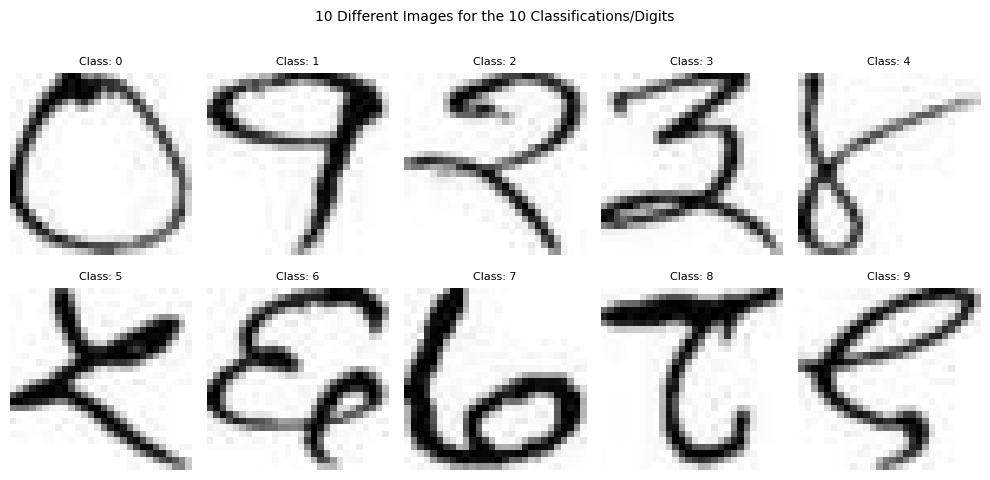

In [ ]:
# Problem
#  "Feedforward Neural Network" or a "Multi-Layer Perceptron (MLP)"

## **Step 1: Setting up project structure and dataset for NN**

### Connecting to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Importing all the required libraries
import os
import sys
import zipfile
import tensorflow as tf
import numpy as np
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
import seaborn as sns


### Dataset Prep

#### Unzipping preprocessed combined dataset

In [ ]:
%cd '/content/gdrive/Shareddrives/31005_Machine_Learning'
%ls

/content/gdrive/Shareddrives/31005_Machine_Learning
dataset/  dataset.zip  labels.csv  ML.ipynb  nhcd/  trial/


In [ ]:
# !unzip dataset.zip DO NOT RUN AGAIN

Streaming output truncated to the last 5000 lines.
  inflating: nhcd/nhcd/numerals/1/028_01.jpg  
  inflating: nhcd/nhcd/numerals/1/028_02.jpg  
  inflating: nhcd/nhcd/numerals/1/028_03.jpg  
  inflating: nhcd/nhcd/numerals/1/028_04.jpg  
  inflating: nhcd/nhcd/numerals/1/028_05.jpg  
  inflating: nhcd/nhcd/numerals/1/029_01.jpg  
  inflating: nhcd/nhcd/numerals/1/030_01.jpg  
  inflating: nhcd/nhcd/numerals/1/030_02.jpg  
  inflating: nhcd/nhcd/numerals/1/030_03.jpg  
  inflating: nhcd/nhcd/numerals/1/030_04.jpg  
  inflating: nhcd/nhcd/numerals/1/032_01.jpg  
  inflating: nhcd/nhcd/numerals/1/032_02.jpg  
  inflating: nhcd/nhcd/numerals/1/033_01.jpg  
  inflating: nhcd/nhcd/numerals/1/033_02.jpg  
  inflating: nhcd/nhcd/numerals/1/034_01.jpg  
  inflating: nhcd/nhcd/numerals/1/034_02.jpg  
  inflating: nhcd/nhcd/numerals/1/035_01.jpg  
  inflating: nhcd/nhcd/numerals/1/035_02.jpg  
  inflating: nhcd/nhcd/numerals/1/036_01.jpg  
  inflating: nhcd/nhcd/numerals/1/036_02.jpg  
  inflati

In [ ]:
# !mkdir '/content/gdrive/Shareddrives/31005_Machine_Learning/dataset' # already made - DO NOT RUN AGAIN

In [ ]:
# !mkdir '/content/gdrive/Shareddrives/31005_Machine_Learning/trial' # already made - DO NOT RUN AGAIN

In [3]:
# Define the source directory where the digit folders are located
source_dir = '/content/gdrive/Shareddrives/31005_Machine_Learning/dataset/numerals'

# Define the destination directories for train, validation, and test splits
train_dir = '/content/gdrive/Shareddrives/31005_Machine_Learning/trial/dataset/numerals_train'
validation_dir = '/content/gdrive/Shareddrives/31005_Machine_Learning/trial/dataset/numerals_validation'
test_dir = '/content/gdrive/Shareddrives/31005_Machine_Learning/trial/dataset/numerals_test'


np.random.seed(0) # This is done to ensure reproducibility in random number generation

# Define the class labels and output size
class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
output_size = len(class_labels)

In [ ]:
# # Create destination directories if they don't exist
# for directory in [train_dir, validation_dir, test_dir]:
#     if not os.path.exists(directory):
#         os.makedirs(directory)

# %pwd ## everything is like /content/gdrive/Shareddrives/31005_Machine_Learning/trial/dataset/numerals_test
#  DO NOT RUN AGAIN

'/content/gdrive/Shareddrives/31005_Machine_Learning/trial'

In [ ]:
# %cd /content/gdrive/Shareddrives/31005_Machine_Learning/trial
# # Initialize counters for each class
# class_counts = {str(i): 0 for i in range(10)}
# source_dir = '/content/gdrive/Shareddrives/31005_Machine_Learning/dataset/numerals'
# # Iterate through each digit folder (0 to 9)
# for digit in range(10):
#     digit_folder = os.path.join(source_dir, str(digit))

#     # Get a list of image files in the folder
#     image_files = [filename for filename in os.listdir(digit_folder) if filename.endswith('.jpg')]

#     # Split the image files into train, validation, and test sets
#     train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)
#     val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

#     # Copy images to the respective directories with modified names
#     for filename in train_files:
#         src_path = os.path.join(digit_folder, filename)
#         dst_filename = f"{digit}_{filename}"  # Modified filename
#         dst_path = os.path.join(train_dir, dst_filename)
#         shutil.copy(src_path, dst_path)
#         class_counts[str(digit)] += 1

#     for filename in val_files:
#         src_path = os.path.join(digit_folder, filename)
#         dst_filename = f"{digit}_{filename}"  # Modified filename
#         dst_path = os.path.join(validation_dir, dst_filename)
#         shutil.copy(src_path, dst_path)
#         class_counts[str(digit)] += 1

#     for filename in test_files:
#         src_path = os.path.join(digit_folder, filename)
#         dst_filename = f"{digit}_{filename}"  # Modified filename
#         dst_path = os.path.join(test_dir, dst_filename)
#         shutil.copy(src_path, dst_path)
#         class_counts[str(digit)] += 1
# DO NOT RUN AGAIN

/content/gdrive/Shareddrives/31005_Machine_Learning/trial


In [4]:
def load_and_preprocess_images_from_directory(directory, output_size):
    print(f"Loading and Preprocessing Data from {directory}")
    images = []
    labels = []
    problematic_files = []  # List to store problematic file names
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            parts = filename.split('_')  # Split the filename into label and original name parts
            # print(parts)
            # print(len(parts))
            if len(parts) == 3:
                # print("inside len(parts)")
                label = int(parts[0])  # Extract the label from the filename
                try:
                    # Load the image
                    image = Image.open(os.path.join(directory, filename))
                    image_array = np.array(image)
                    # Normalize pixel values to [0, 1]
                    image_array = image_array / 255.0

                    # Append the preprocessed image and label
                    images.append(image_array)

                    # Ensure that y_batch is one-hot encoded with the correct shape
                    y_batch_one_hot = np.zeros(output_size)
                    y_batch_one_hot[label] = 1  # Set the appropriate index to 1
                    labels.append(y_batch_one_hot)
                except Exception as e:
                    # If there's an error while processing the image, log the filename
                    problematic_files.append(filename)
                    print(f"Error processing {filename}: {str(e)}")

    if problematic_files:
        print("Problematic files:", problematic_files)

    sys.stdout.flush()  # Force the output to be displayed immediately

    return np.array(images), np.array(labels)

In [6]:
# Load and preprocess the images from train, validation, and test directories
X_train, y_train = load_and_preprocess_images_from_directory(train_dir, output_size)
X_val, y_val = load_and_preprocess_images_from_directory(validation_dir, output_size)
X_test, y_test = load_and_preprocess_images_from_directory(test_dir, output_size)

Loading and Preprocessing Data from /content/gdrive/Shareddrives/31005_Machine_Learning/trial/dataset/numerals_train
Loading and Preprocessing Data from /content/gdrive/Shareddrives/31005_Machine_Learning/trial/dataset/numerals_validation
Loading and Preprocessing Data from /content/gdrive/Shareddrives/31005_Machine_Learning/trial/dataset/numerals_test


In [ ]:
print(f"X_train: {X_train} \ny_train: {y_train}")
print(f"X_train.shape: {X_train.shape} \ny_train.shape: {y_train.shape}")

X_train: [[[1.         0.97647059 0.98039216 ... 0.98823529 0.99215686 1.        ]
  [0.99607843 0.99607843 1.         ... 1.         0.98823529 1.        ]
  [0.98431373 1.         1.         ... 1.         0.98431373 1.        ]
  ...
  [0.99215686 0.99215686 0.99215686 ... 0.61176471 0.81176471 0.96862745]
  [1.         1.         1.         ... 0.22745098 0.32941176 0.66666667]
  [1.         1.         1.         ... 0.45882353 0.31372549 0.62745098]]

 [[1.         1.         1.         ... 0.94117647 1.         0.99607843]
  [1.         1.         1.         ... 0.96862745 1.         1.        ]
  [1.         1.         1.         ... 0.76078431 0.96862745 0.99215686]
  ...
  [0.99215686 0.99215686 0.99215686 ... 0.42745098 0.38823529 0.80784314]
  [1.         1.         1.         ... 0.19607843 0.34509804 0.68627451]
  [1.         1.         1.         ... 0.67058824 0.82745098 0.98431373]]

 [[1.         1.         1.         ... 0.97647059 0.69411765 0.41568627]
  [1.        

In [12]:
# Assuming your images are grayscale and stored as 28x28 images
# Flatten and preprocess the input data
X_train = X_train.reshape(-1, 784)  # Reshape to (number_of_samples, 784)
X_train = X_train / 255.0  # Normalize pixel values to [0, 1]

X_val = X_val.reshape(-1, 784)  # Reshape to (number_of_samples, 784)
X_val = X_val / 255.0  # Normalize pixel values to [0, 1]

# Similarly, preprocess the test data
X_test = X_test.reshape(-1, 784)
X_test = X_test / 255.0

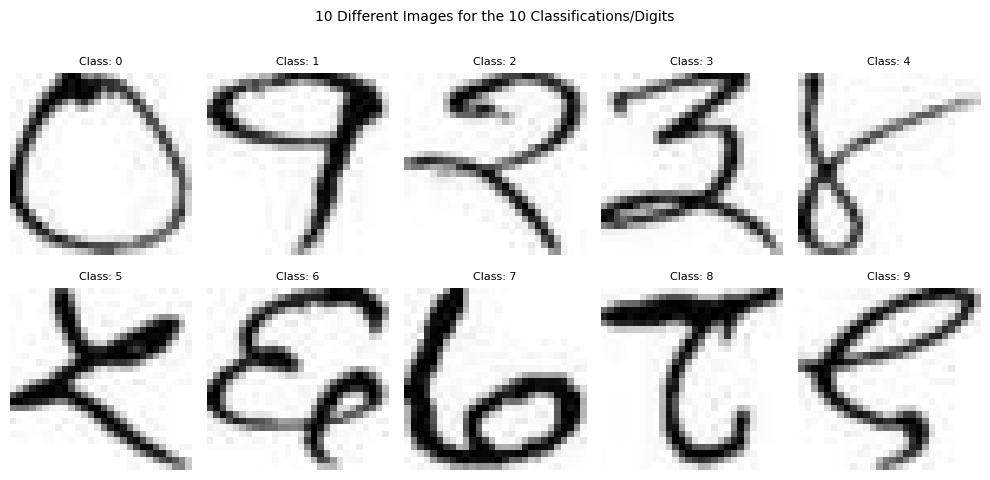

In [ ]:
# Get the list of image names (assuming your filenames are available)
image_names = [filename for filename in os.listdir(test_dir) if filename.endswith('.jpg')]

# Initialize a list to store unique class labels
unique_labels = []

# Visualize some results along with image names, real labels, and predictions
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
for i, filename in enumerate(image_names):
    if len(unique_labels) == 10:
        break

    image = X_test[i].reshape(28, 28)
    label = np.argmax(y_test[i])  # Convert one-hot encoding to label

    if label not in unique_labels:
        plt.subplot(2, 5, len(unique_labels) + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Class: {label}", fontsize=8)
        plt.axis('off')
        unique_labels.append(label)

plt.suptitle("10 Different Images for the 10 Classifications/Digits", fontsize=10, y=0.995)
plt.tight_layout()
plt.show()


## Step 1.5 Creating Neural Networks

In [7]:
# Define the sigmoid activation function and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

# Define the softmax function for the output layer
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Subtracting max(x) for numerical stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Experiment with a different activation function (e.g., ReLU)
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

### Original Neural Network (weights + bias + ReLU + Softmax + Train & Test)

In [ ]:
# Define a neural network class
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        # Initialize weights and biases
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_output = np.zeros((1, output_size))

   # Modify the forward and backward functions to use ReLU
    def forward(self, X):
        # Feedforward operation with ReLU activation for the hidden layer
        self.hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = relu(self.hidden_input)
        self.output = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.output_probabilities = softmax(self.output)
        return self.output_probabilities

    def backward(self, X, y):
        # Backpropagation with ReLU derivative
        batch_size = X.shape[0]
        d_output = self.output_probabilities - y
        d_hidden = np.dot(d_output, self.weights_hidden_output.T) * relu_derivative(self.hidden_output)

        # Update weights and biases
        self.weights_hidden_output -= self.learning_rate * np.dot(self.hidden_output.T, d_output) / batch_size
        self.bias_output -= self.learning_rate * np.sum(d_output, axis=0, keepdims=True) / batch_size
        self.weights_input_hidden -= self.learning_rate * np.dot(X.T, d_hidden) / batch_size
        self.bias_hidden -= self.learning_rate * np.sum(d_hidden, axis=0, keepdims=True) / batch_size

    def train(self, X, y, epochs):
        for epoch in range(epochs):
            output = self.forward(X)
            self.backward(X, y)
            loss = -np.sum(y * np.log(output)) / len(X)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

### Neural Network 2 (weights + bias + ReLU + Softmax + Train, Val & Test + measuring metrics)

In [8]:
class NeuralNetwork_TVT_mertics:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_output = np.zeros((1, output_size))

        self.train_losses = []  # Store training loss for each epoch
        self.val_losses = []  # Store validation loss for each epoch
        self.train_accuracies = []  # Store training accuracy for each epoch
        self.val_accuracies = []  # Store validation accuracy for each epoch

    def forward(self, X):
        self.hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = relu(self.hidden_input)
        self.output = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.output_probabilities = softmax(self.output)
        return self.output_probabilities

    def backward(self, X, y):
        batch_size = X.shape[0]
        d_output = self.output_probabilities - y
        d_hidden = np.dot(d_output, self.weights_hidden_output.T) * relu_derivative(self.hidden_output)

        self.weights_hidden_output -= self.learning_rate * np.dot(self.hidden_output.T, d_output) / batch_size
        self.bias_output -= self.learning_rate * np.sum(d_output, axis=0, keepdims=True) / batch_size
        self.weights_input_hidden -= self.learning_rate * np.dot(X.T, d_hidden) / batch_size
        self.bias_hidden -= self.learning_rate * np.sum(d_hidden, axis=0, keepdims=True) / batch_size

    def train(self, X_train, y_train, X_val, y_val, epochs):
        for epoch in range(epochs):
            # Training
            output = self.forward(X_train)
            self.backward(X_train, y_train)
            train_loss = -np.sum(y_train * np.log(output)) / len(X_train)
            self.train_losses.append(train_loss)

            # Validation
            val_output = self.forward(X_val)
            val_loss = -np.sum(y_val * np.log(val_output)) / len(X_val)
            self.val_losses.append(val_loss)

            # Calculate and store training accuracy
            train_predictions = self.predict(X_train)
            train_accuracy = np.mean(train_predictions == np.argmax(y_train, axis=1))
            self.train_accuracies.append(train_accuracy)

            # Calculate and store validation accuracy
            val_predictions = self.predict(X_val)
            val_accuracy = np.mean(val_predictions == np.argmax(y_val, axis=1))
            self.val_accuracies.append(val_accuracy)

            # Print training and validation metrics
            print(f"Epoch {epoch + 1}/{epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

# Function to load and preprocess images from a directory
def load_and_preprocess_images_from_directory(directory, output_size):
    images = []
    labels = []
    problematic_files = []  # List to store problematic file names
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            parts = filename.split('_')  # Split the filename into label and original name parts
            if len(parts) == 3:
                label = int(parts[0])  # Extract the label from the filename
                try:
                    # Load the image
                    image = Image.open(os.path.join(directory, filename))
                    image_array = np.array(image)

                    # Normalize pixel values to [0, 1]
                    image_array = image_array / 255.0

                    # Append the preprocessed image and label
                    images.append(image_array)

                    # Ensure that y_batch is one-hot encoded with the correct shape
                    y_batch_one_hot = np.zeros(output_size)
                    y_batch_one_hot[label] = 1  # Set the appropriate index to 1
                    labels.append(y_batch_one_hot)
                except Exception as e:
                    # If there's an error while processing the image, log the filename
                    problematic_files.append(filename)
                    print(f"Error processing {filename}: {str(e)}")

    if problematic_files:
        print("Problematic files:", problematic_files)

    sys.stdout.flush()  # Force the output to be displayed immediately
    print(f"Number of images: {len(images)}\nNumber of labels: {len(labels)}")
    return np.array(images), np.array(labels)


### Neural Network 3 (weights + bias + ReLU + Softmax + Train, Val & Test + measuring metrics + dropouts)

In [39]:
class NeuralNetwork_TVT_mertics_dropout:
    def __init__(self, input_size, hidden_size, output_size, learning_rate, dropout_prob):
        # Initialize network architecture and hyperparameters
        self.input_size = input_size  # Number of input features
        self.hidden_size = hidden_size  # Number of neurons in the hidden layer
        self.output_size = output_size  # Number of output classes
        self.learning_rate = learning_rate  # Learning rate for weight updates
        self.dropout_prob = dropout_prob  # Dropout probability

        # Initialize weights with a standard normal distribution
        # Weights connect input to the hidden layer and hidden layer to the output layer
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) / np.sqrt(input_size)
        self.bias_hidden = np.zeros((1, hidden_size))  # Bias for the hidden layer
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size)
        self.bias_output = np.zeros((1, output_size))  # Bias for the output layer

        # Lists to store training and validation metrics for each epoch
        self.train_losses = []  # Store training loss for each epoch
        self.val_losses = []  # Store validation loss for each epoch
        self.train_accuracies = []  # Store training accuracy for each epoch
        self.val_accuracies = []  # Store validation accuracy for each epoch

    def forward(self, X, is_training=True):
        # Forward pass through the neural network
        self.hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = relu(self.hidden_input)  # Apply ReLU activation function to the hidden layer

        # Apply dropout during training
        if is_training:
            # Generate a dropout mask that randomly deactivates neurons
            # This prevents over-reliance on specific neurons during training
            dropout_mask = (np.random.rand(*self.hidden_output.shape) < self.dropout_prob) / (1 - self.dropout_prob)
            self.hidden_output *= dropout_mask

        self.output = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.output_probabilities = softmax(self.output)  # Apply softmax for multiclass classification
        return self.output_probabilities

    def backward(self, X, y):
        # Backward pass to update weights and biases using backpropagation
        batch_size = X.shape[0]
        d_output = self.output_probabilities - y  # Calculate the gradient of the loss with respect to the output
        d_hidden = np.dot(d_output, self.weights_hidden_output.T) * relu_derivative(self.hidden_output)

        # Update weights and biases using the calculated gradients
        # This is the essence of the backpropagation algorithm
        self.weights_hidden_output -= self.learning_rate * np.dot(self.hidden_output.T, d_output) / batch_size
        self.bias_output -= self.learning_rate * np.sum(d_output, axis=0, keepdims=True) / batch_size
        self.weights_input_hidden -= self.learning_rate * np.dot(X.T, d_hidden) / batch_size
        self.bias_hidden -= self.learning_rate * np.sum(d_hidden, axis=0, keepdims=True) / batch_size

    def train(self, X_train, y_train, X_val, y_val, epochs):
        # Training the neural network for a specified number of epochs
        for epoch in range(epochs):
            # Training
            output = self.forward(X_train, is_training=True)
            self.backward(X_train, y_train)
            train_loss = -np.sum(y_train * np.log(output)) / len(X_train)  # Compute the cross-entropy loss
            self.train_losses.append(train_loss)

            # Validation
            val_output = self.forward(X_val, is_training=False)  # Disable dropout during validation
            val_loss = -np.sum(y_val * np.log(val_output)) / len(X_val)  # Compute the cross-entropy loss for validation
            self.val_losses.append(val_loss)

            # Calculate and store training accuracy
            train_predictions = self.predict(X_train)
            train_accuracy = np.mean(train_predictions == np.argmax(y_train, axis=1))
            self.train_accuracies.append(train_accuracy)

            # Calculate and store validation accuracy
            val_predictions = self.predict(X_val)
            val_accuracy = np.mean(val_predictions == np.argmax(y_val, axis=1))
            self.val_accuracies.append(val_accuracy)

            # Print training and validation metrics
            print(f"Epoch {epoch + 1}/{epochs}")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%")

    def predict(self, X):
        # Predict the classes for input data
        return np.argmax(self.forward(X, is_training=False), axis=1)

## **Step 2: Train Models on**

### Using orginal model (weights + bias + ReLU + Softmax + Train & Test) Best: 71.4%
*   input_size = 784  # 28x28 = 784 pixels
*   output_size = 10  
*   hidden_size = 2048
*   learning_rate = 0.01

1.   Initial Experiment (1 epoch)
2.   Improved Experiment (1000 epochs)

#### Intial Model
*   input_size = 784  # 28x28 = 784 pixels
*   output_size = 10  # 10 classes
*   hidden_size = 2048 # 512 # 1024
*   learning_rate = 0.01 # 0.01 seems good, 0.1 is not the best
*   epochs = 1

##### Initialise and Train Model

###### Hyperparameters

In [ ]:
# Create and train the neural network
input_size = 784  # 28x28 = 784 pixels
output_size = 10  # 10 classes

# these are the hyperparmeters
hidden_size = 2048 # 512 # 1024
learning_rate = 0.01 # 0.01 seems good, 0.1 is not the best
epochs = 1


In [ ]:
nn_784_2048_10_01_1 = NeuralNetwork(input_size, hidden_size, output_size, learning_rate)

In [ ]:
nn_784_2048_10_01_1.train(X_train, y_train, epochs)

Epoch 1/1, Loss: 4.5439


##### Predict using trained model

In [ ]:
# Make predictions on new data
predictions = nn_784_2048_10_01_1.predict(X_test)
print("Predictions:", predictions)


Predictions: [5 4 1 6 6 1 6 6 6 6 2 6 1 3 6 6 3 6 1 4 6 6 6 6 6 6 3 5 6 4 6 6 6 6 4 1 6
 3 6 6 9 6 9 6 6 6 4 7 6 9 6 4 9 7 9 6 5 9 6 5 6 6 4 4 6 6 6 5 9 9 4 5 6 6
 6 4 6 7 4 6 9 4 6 4 6 6 6 6 6 5 7 2 6 6 6 5 2 7 7 5 6 2 1 1 8 5 5 5 5 6 1
 5 5 6 6 6 5 6 6 6 6 6 5 3 6 7 3 5 3 5 6 5 5 6 3 1 3 7 6 5 6 5 6 0 5 7 0 6
 5 6 8 1 1 7 5 7 5 6 7 0 6 2 5 4 3 7 0 6 5 1 5 6 1 4 8 7 0 4 0 5 6 5 6 5 1
 6 6 6 1 6 0 1 5 6 6 6 6 6 6 1 1 6 5 5 5 1 6 5 5 6 6 5 6 2 5 0 6 5 0 6 5 1
 5 5 0 6 6 5 0 7 0 0 5 5 5 5 5 0 6 7 5 6 5 0 0 5 5 0 1 7 5 5 6 2 5 5 1 8 5
 5 5 5 5 5 3 9 1 6 6 9 6 5 9 5 6 5 5 9 5 5 2 6 4 4 9 1 5 5 5 4 2 6 9 6 7 1
 6 4 5 6 9 9 1 9 9 4 4 1 6 4 6 6 1 2 2 0 6 2 1 9 2 1 5 0 2 6 2 2 1 5 2 6 4
 9 6 6 6 1 6 1 6 6 2 6 2 2 4 1 6 2 9 2 0 1 5 5 1 5 5 5 6 1 1 1 1 6 5 6 1 6
 5 1 5 5 5 0 6 5 1 1 5 5 6 1 1 1 5 5 1 5 6 6 1 5 0 6 5 5 1 6 5 1 6 5 1 5 6
 0 6 5 4 5 5 6 1 6 5 1 0 6 5 5 5 1 9 9 6 0 6 6 5 5 6 5 6 5 6 1 9 6]


##### Visualisation

Accuracy: 9.55%


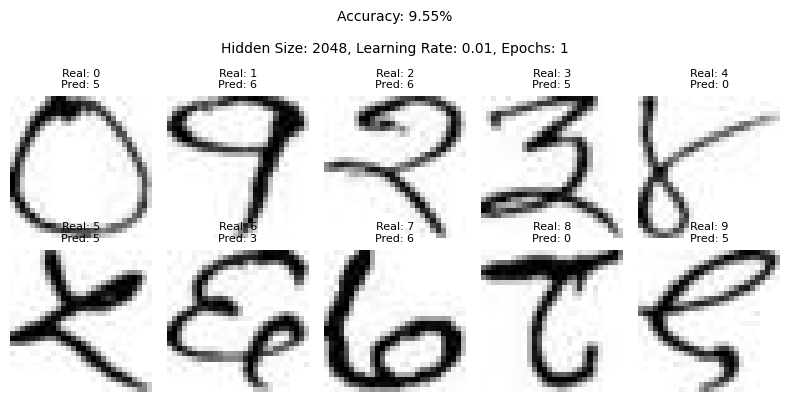

In [ ]:
accuracy = np.mean(predictions == np.argmax(y_test, axis=1))
print(f"Accuracy: {accuracy * 100:.2f}%")
# Initialize a list to store unique class labels and their corresponding predictions
unique_labels = []

# Set the figure size and adjust the image size
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
for i, filename in enumerate(image_names):
    if len(unique_labels) == 10:
        break

    image = X_test[i].reshape(28, 28)
    label = np.argmax(y_test[i])  # Convert one-hot encoding to label
    prediction = predictions[i]

    if label not in unique_labels:
        plt.subplot(2, 5, len(unique_labels) + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Real: {label}\nPred: {prediction}", fontsize=8)
        plt.axis('off')
        unique_labels.append(label)

# Add an overall title with accuracy
accuracy_text = f"Accuracy: {accuracy * 100:.2f}%\n\nHidden Size: {hidden_size}, Learning Rate: {learning_rate}, Epochs: {epochs}"
plt.suptitle(accuracy_text, fontsize=10, y=0.995)  # Adjust fontsize and position as needed
plt.tight_layout()
plt.show()


#### Model - nn_784_2048_10_01_1000: Accuracy: 71.14%

*   input_size = 784  # 28x28 = 784 pixels
*   output_size = 10  # 10 classes
*   hidden_size = 2048 # 512 # 1024
*   learning_rate = 0.01 # 0.01 seems good, 0.1 is not the best
*   epochs = 1000

##### Initialise and Train Model

###### Hyperparameters

In [ ]:
# Create and train the neural network
input_size = 784  # 28x28 = 784 pixels
output_size = 10  # 10 classes

# these are the hyperparmeters
hidden_size = 2048 # 512 # 1024
learning_rate = 0.01 # 0.01 seems good, 0.1 is not the best
epochs = 1000


In [ ]:
nn_784_2048_10_01_1000 = NeuralNetwork(input_size, hidden_size, output_size, learning_rate)

In [ ]:
nn_784_2048_10_01_1000.train(X_train, y_train, epochs)

Epoch 1/1000, Loss: 6.1890
Epoch 2/1000, Loss: 3.9923
Epoch 3/1000, Loss: 3.3868
Epoch 4/1000, Loss: 3.1466
Epoch 5/1000, Loss: 2.9847
Epoch 6/1000, Loss: 2.8793
Epoch 7/1000, Loss: 2.8225
Epoch 8/1000, Loss: 2.7909
Epoch 9/1000, Loss: 2.7673
Epoch 10/1000, Loss: 2.7454
Epoch 11/1000, Loss: 2.7239
Epoch 12/1000, Loss: 2.7028
Epoch 13/1000, Loss: 2.6820
Epoch 14/1000, Loss: 2.6615
Epoch 15/1000, Loss: 2.6414
Epoch 16/1000, Loss: 2.6217
Epoch 17/1000, Loss: 2.6024
Epoch 18/1000, Loss: 2.5836
Epoch 19/1000, Loss: 2.5651
Epoch 20/1000, Loss: 2.5470
Epoch 21/1000, Loss: 2.5292
Epoch 22/1000, Loss: 2.5118
Epoch 23/1000, Loss: 2.4946
Epoch 24/1000, Loss: 2.4777
Epoch 25/1000, Loss: 2.4612
Epoch 26/1000, Loss: 2.4449
Epoch 27/1000, Loss: 2.4288
Epoch 28/1000, Loss: 2.4131
Epoch 29/1000, Loss: 2.3976
Epoch 30/1000, Loss: 2.3824
Epoch 31/1000, Loss: 2.3676
Epoch 32/1000, Loss: 2.3529
Epoch 33/1000, Loss: 2.3385
Epoch 34/1000, Loss: 2.3243
Epoch 35/1000, Loss: 2.3104
Epoch 36/1000, Loss: 2.2967
E

##### Predict using trained model

In [ ]:
# Make predictions on new data
predictions_784_2048_10_01_1000 = nn_784_2048_10_01_1000.predict(X_test)
print("Predictions:", predictions_784_2048_10_01_1000)


Predictions: [7 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 2 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0
 0 0 0 7 0 0 0 1 1 9 9 9 1 1 1 1 7 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 9 1
 9 1 1 1 1 1 1 1 1 9 1 1 1 1 9 2 3 2 2 5 2 2 2 3 3 2 5 3 2 5 2 2 2 2 2 3 3
 2 3 2 3 2 2 2 2 2 2 2 2 3 3 1 5 2 2 3 3 6 3 7 3 3 6 3 9 3 2 3 3 2 3 3 1 2
 3 2 0 6 0 3 3 5 3 7 3 6 3 3 2 2 3 0 3 8 6 0 3 3 0 9 2 4 5 7 4 4 4 4 5 9 5
 4 4 4 7 4 9 5 5 5 4 4 4 4 6 4 4 4 4 7 6 4 4 7 2 5 4 4 4 5 4 4 4 4 4 4 5 5
 5 5 5 5 5 3 2 5 2 5 5 5 5 5 5 2 2 5 5 5 9 5 5 5 7 5 6 5 1 5 6 3 5 5 5 5 5
 2 3 2 5 4 6 6 6 6 6 6 3 6 2 9 8 6 6 6 6 6 6 9 9 9 2 6 6 6 9 6 6 8 9 4 6 6
 6 6 6 6 6 6 6 6 6 6 7 6 7 7 7 7 6 7 7 4 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7
 7 7 7 7 2 7 7 7 7 0 6 7 7 7 7 7 0 7 7 8 8 8 8 8 8 8 6 8 8 8 9 8 8 6 8 8 8
 8 8 8 5 8 4 5 8 8 7 8 8 8 8 8 6 8 6 8 8 8 8 8 8 8 8 9 9 9 1 9 9 8 9 9 9 4
 4 9 9 4 9 9 9 9 9 9 6 5 9 9 9 8 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9]


##### Visualisation

Accuracy: 71.14%


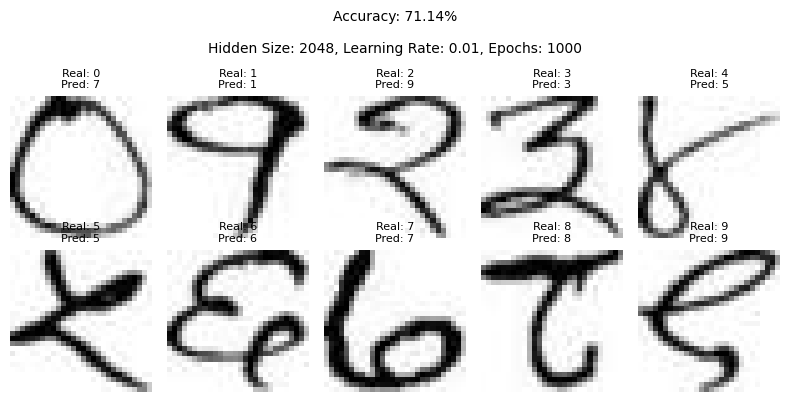

In [ ]:
accuracy_784_2048_10_01_1000 = np.mean(predictions_784_2048_10_01_1000 == np.argmax(y_test, axis=1))
print(f"Accuracy: {accuracy_784_2048_10_01_1000 * 100:.2f}%")
# Initialize a list to store unique class labels and their corresponding predictions
unique_labels = []

# Set the figure size and adjust the image size
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
for i, filename in enumerate(image_names):
    if len(unique_labels) == 10:
        break

    image_784_2048_10_01_1000 = X_test[i].reshape(28, 28)
    label_784_2048_10_01_1000 = np.argmax(y_test[i])  # Convert one-hot encoding to label
    prediction_784_2048_10_01_1000 = predictions_784_2048_10_01_1000[i]

    if label_784_2048_10_01_1000 not in unique_labels:
        plt.subplot(2, 5, len(unique_labels) + 1)
        plt.imshow(image_784_2048_10_01_1000, cmap='gray')
        plt.title(f"Real: {label_784_2048_10_01_1000}\nPred: {prediction_784_2048_10_01_1000}", fontsize=8)
        plt.axis('off')
        unique_labels.append(label_784_2048_10_01_1000)

# Add an overall title with accuracy
accuracy_text_784_2048_10_01_1000 = f"Accuracy: {accuracy_784_2048_10_01_1000 * 100:.2f}%\n\nHidden Size: {hidden_size}, Learning Rate: {learning_rate}, Epochs: {epochs}"
plt.suptitle(accuracy_text_784_2048_10_01_1000, fontsize=10, y=0.995)  # Adjust fontsize and position as needed
plt.tight_layout()
plt.show()


### Using updated model (weights + bias + ReLU + Softmax + Train, Val & Test + Metrics) Best: 71.14%
*   input_size = 784  # 28x28 = 784 pixels
*   output_size = 10  
*   hidden_size = 2048
*   learning_rate = 0.01

1.   Initial Experiment (1 epoch)
2.   Improved Experiment (1000 epochs)

#### Intial Model NeuralNetwork_TVT_mertics
*   input_size = 784  # 28x28 = 784 pixels
*   output_size = 10  # 10 classes
*   hidden_size = 2048 # 512 # 1024
*   learning_rate = 0.01 # 0.01 seems good, 0.1 is not the best
*   epochs = 1

##### Initialise and Train Model

###### Hyperparameters

In [9]:
# Create and train the neural network
input_size = 784  # 28x28 = 784 pixels
output_size = 10  # 10 classes

# these are the hyperparmeters
hidden_size = 2048 # 512 # 1024
learning_rate = 0.01 # 0.01 seems good, 0.1 is not the best
epochs = 1

In [10]:
nntvt_784_2048_10_01_1 = NeuralNetwork_TVT_mertics(input_size, hidden_size, output_size, learning_rate)

In [13]:
nntvt_784_2048_10_01_1.train(X_train, y_train, X_val, y_val, epochs)

Epoch 1/1
Train Loss: 4.5439, Train Accuracy: 8.01%
Validation Loss: 3.3262, Validation Accuracy: 7.21%


##### Predict using trained model

In [14]:
# Make predictions on new data
predictions = nntvt_784_2048_10_01_1.predict(X_test)
print("Predictions:", predictions)

Predictions: [5 4 1 6 6 1 6 6 6 6 2 6 1 3 6 6 3 6 1 4 6 6 6 6 6 6 3 5 6 4 6 6 6 6 4 1 6
 3 6 6 9 6 9 6 6 6 4 7 6 9 6 4 9 7 9 6 5 9 6 5 6 6 4 4 6 6 6 5 9 9 4 5 6 6
 6 4 6 7 4 6 9 4 6 4 6 6 6 6 6 5 7 2 6 6 6 5 2 7 7 5 6 2 1 1 8 5 5 5 5 6 1
 5 5 6 6 6 5 6 6 6 6 6 5 3 6 7 3 5 3 5 6 5 5 6 3 1 3 7 6 5 6 5 6 0 5 7 0 6
 5 6 8 1 1 7 5 7 5 6 7 0 6 2 5 4 3 7 0 6 5 1 5 6 1 4 8 7 0 4 0 5 6 5 6 5 1
 6 6 6 1 6 0 1 5 6 6 6 6 6 6 1 1 6 5 5 5 1 6 5 5 6 6 5 6 2 5 0 6 5 0 6 5 1
 5 5 0 6 6 5 0 7 0 0 5 5 5 5 5 0 6 7 5 6 5 0 0 5 5 0 1 7 5 5 6 2 5 5 1 8 5
 5 5 5 5 5 3 9 1 6 6 9 6 5 9 5 6 5 5 9 5 5 2 6 4 4 9 1 5 5 5 4 2 6 9 6 7 1
 6 4 5 6 9 9 1 9 9 4 4 1 6 4 6 6 1 2 2 0 6 2 1 9 2 1 5 0 2 6 2 2 1 5 2 6 4
 9 6 6 6 1 6 1 6 6 2 6 2 2 4 1 6 2 9 2 0 1 5 5 1 5 5 5 6 1 1 1 1 6 5 6 1 6
 5 1 5 5 5 0 6 5 1 1 5 5 6 1 1 1 5 5 1 5 6 6 1 5 0 6 5 5 1 6 5 1 6 5 1 5 6
 0 6 5 4 5 5 6 1 6 5 1 0 6 5 5 5 1 9 9 6 0 6 6 5 5 6 5 6 5 6 1 9 6]


##### Visualisation

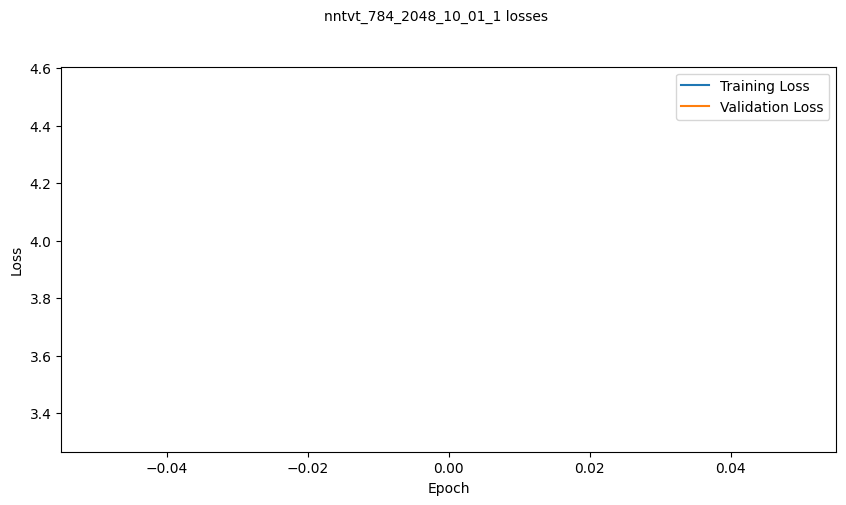

In [15]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(nntvt_784_2048_10_01_1.train_losses, label="Training Loss")
plt.plot(nntvt_784_2048_10_01_1.val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.suptitle("nntvt_784_2048_10_01_1 losses", fontsize=10, y=0.995)
plt.show()

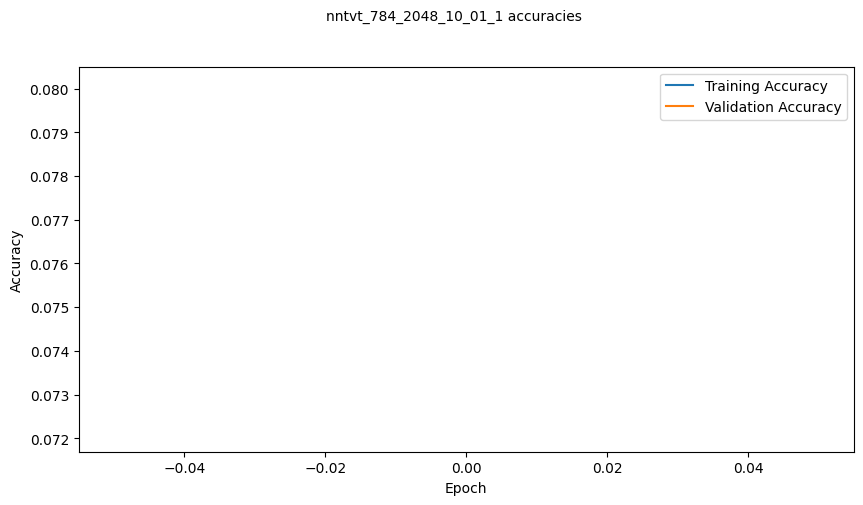

In [16]:
# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(nntvt_784_2048_10_01_1.train_accuracies, label="Training Accuracy")
plt.plot(nntvt_784_2048_10_01_1.val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.suptitle("nntvt_784_2048_10_01_1 accuracies", fontsize=10, y=0.995)
plt.show()

In [17]:
# Make predictions on test data
predictions = nntvt_784_2048_10_01_1.predict(X_test)
print("Predictions:", predictions)

# Calculate and display accuracy for the test set
accuracy = np.mean(predictions == np.argmax(y_test, axis=1))
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Predictions: [5 4 1 6 6 1 6 6 6 6 2 6 1 3 6 6 3 6 1 4 6 6 6 6 6 6 3 5 6 4 6 6 6 6 4 1 6
 3 6 6 9 6 9 6 6 6 4 7 6 9 6 4 9 7 9 6 5 9 6 5 6 6 4 4 6 6 6 5 9 9 4 5 6 6
 6 4 6 7 4 6 9 4 6 4 6 6 6 6 6 5 7 2 6 6 6 5 2 7 7 5 6 2 1 1 8 5 5 5 5 6 1
 5 5 6 6 6 5 6 6 6 6 6 5 3 6 7 3 5 3 5 6 5 5 6 3 1 3 7 6 5 6 5 6 0 5 7 0 6
 5 6 8 1 1 7 5 7 5 6 7 0 6 2 5 4 3 7 0 6 5 1 5 6 1 4 8 7 0 4 0 5 6 5 6 5 1
 6 6 6 1 6 0 1 5 6 6 6 6 6 6 1 1 6 5 5 5 1 6 5 5 6 6 5 6 2 5 0 6 5 0 6 5 1
 5 5 0 6 6 5 0 7 0 0 5 5 5 5 5 0 6 7 5 6 5 0 0 5 5 0 1 7 5 5 6 2 5 5 1 8 5
 5 5 5 5 5 3 9 1 6 6 9 6 5 9 5 6 5 5 9 5 5 2 6 4 4 9 1 5 5 5 4 2 6 9 6 7 1
 6 4 5 6 9 9 1 9 9 4 4 1 6 4 6 6 1 2 2 0 6 2 1 9 2 1 5 0 2 6 2 2 1 5 2 6 4
 9 6 6 6 1 6 1 6 6 2 6 2 2 4 1 6 2 9 2 0 1 5 5 1 5 5 5 6 1 1 1 1 6 5 6 1 6
 5 1 5 5 5 0 6 5 1 1 5 5 6 1 1 1 5 5 1 5 6 6 1 5 0 6 5 5 1 6 5 1 6 5 1 5 6
 0 6 5 4 5 5 6 1 6 5 1 0 6 5 5 5 1 9 9 6 0 6 6 5 5 6 5 6 5 6 1 9 6]
Test Accuracy: 9.55%


Confusion Matrix (Test Set):
[[ 0  5  1  4  4  2 26  0  0  2]
 [ 0  0  0  0  9  4 21  3  0  7]
 [ 0  3  3  3  0 14 16  4  1  0]
 [ 4  5  1  3  2 10 10  7  2  0]
 [ 5  6  1  0  1 12 19  0  0  0]
 [ 8  3  1  0  0 23  5  3  1  0]
 [ 0  5  2  1  6 10  9  1  0 10]
 [ 2  7 13  0  3  2 14  0  0  3]
 [ 3 15  0  0  0 17  9  0  0  0]
 [ 3  7  0  0  1 16 14  0  0  3]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.00      0.00      0.00        44
           2       0.14      0.07      0.09        44
           3       0.27      0.07      0.11        44
           4       0.04      0.02      0.03        44
           5       0.21      0.52      0.30        44
           6       0.06      0.20      0.10        44
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00        44
           9       0.12      0.07      0.09        44

    accur

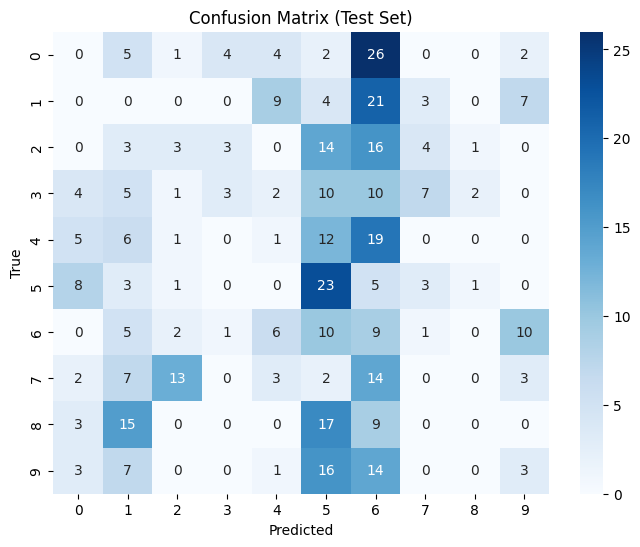

In [18]:
# Calculate confusion matrix and metrics for the test set
test_true_labels = np.argmax(y_test, axis=1)
test_confusion_matrix = confusion_matrix(test_true_labels, predictions)
test_classification_report = classification_report(test_true_labels, predictions, target_names=[str(label) for label in class_labels])

# Print and display the confusion matrix and metrics for the test set
print("Confusion Matrix (Test Set):")
print(test_confusion_matrix)

print("\nClassification Report (Test Set):")
print(test_classification_report)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()


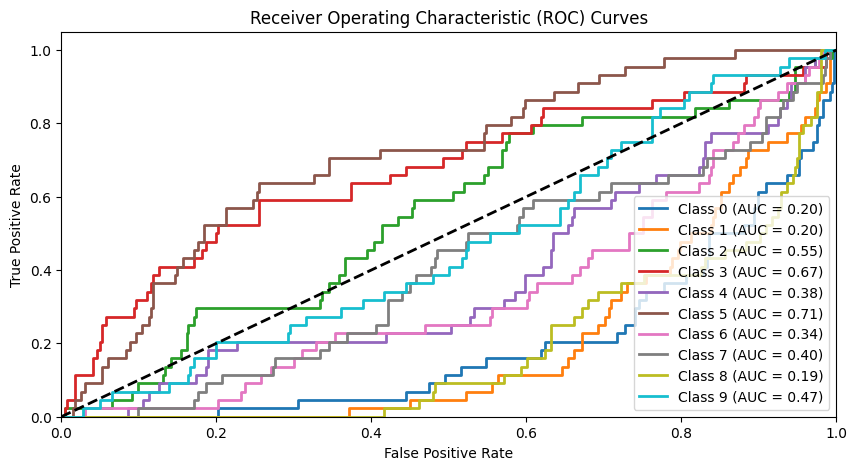

In [20]:
# Plot ROC curves
plt.figure(figsize=(10, 5))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(output_size):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], nntvt_784_2048_10_01_1.forward(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

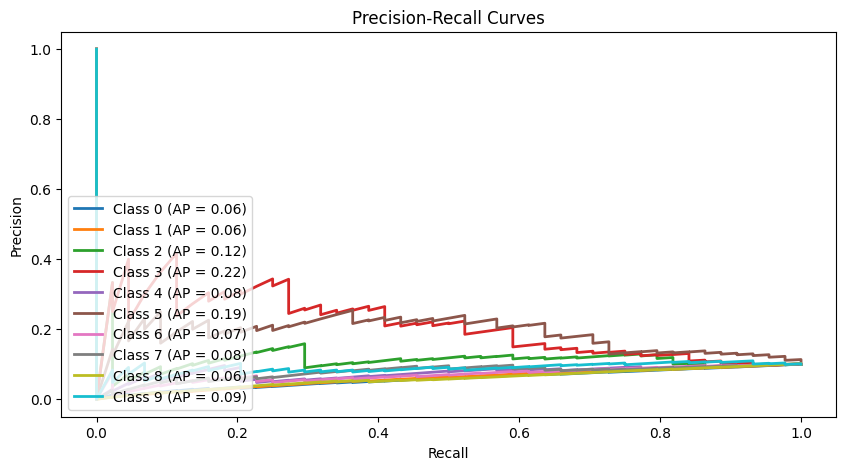

In [21]:
# Plot Precision-Recall curves
plt.figure(figsize=(10, 5))
precision = dict()
recall = dict()
average_precision = dict()
for i in range(output_size):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], nntvt_784_2048_10_01_1.forward(X_test)[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], nntvt_784_2048_10_01_1.forward(X_test)[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()


In [23]:
# Get the list of image names (assuming your filenames are available)
image_names = [filename for filename in os.listdir(test_dir) if filename.endswith('.jpg')]

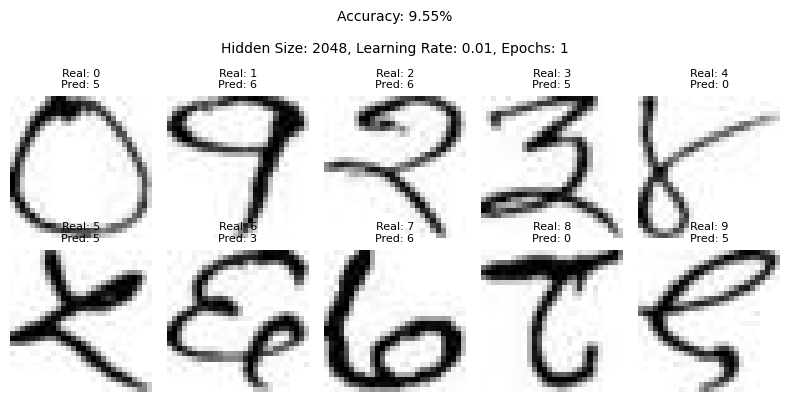

In [25]:
unique_labels = []

# Set the figure size and adjust the image size
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
for i, filename in enumerate(image_names):
    if len(unique_labels) == 10:
        break

    image = X_test[i].reshape(28, 28)
    label = np.argmax(y_test[i])  # Convert one-hot encoding to label
    prediction = predictions[i]

    if label not in unique_labels:
        plt.subplot(2, 5, len(unique_labels) + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Real: {label}\nPred: {prediction}", fontsize=8)
        plt.axis('off')
        unique_labels.append(label)

# Add an overall title with accuracy
accuracy_text = f"Accuracy: {accuracy * 100:.2f}%\n\nHidden Size: {hidden_size}, Learning Rate: {learning_rate}, Epochs: {epochs}"
plt.suptitle(accuracy_text, fontsize=10, y=0.995)  # Adjust fontsize and position as needed
plt.tight_layout()
plt.show()


#### Improved Model NeuralNetwork_TVT_mertics: Accuracy: 71.14%
*   input_size = 784  # 28x28 = 784 pixels
*   output_size = 10  # 10 classes
*   hidden_size = 2048 # 512 # 1024
*   learning_rate = 0.01 # 0.01 seems good, 0.1 is not the best
*   epochs = 1000

##### Initialise and Train Model

###### Hyperparameters

In [26]:
# Create and train the neural network
input_size = 784  # 28x28 = 784 pixels
output_size = 10  # 10 classes

# these are the hyperparmeters
hidden_size = 2048 # 512 # 1024
learning_rate = 0.01 # 0.01 seems good, 0.1 is not the best
epochs = 1000

In [27]:
nntvt_784_2048_10_01_1000 = NeuralNetwork_TVT_mertics(input_size, hidden_size, output_size, learning_rate)

In [28]:
nntvt_784_2048_10_01_1000.train(X_train, y_train, X_val, y_val, epochs)

Epoch 1/1000
Train Loss: 6.1890, Train Accuracy: 12.49%
Validation Loss: 3.9737, Validation Accuracy: 11.40%
Epoch 2/1000
Train Loss: 3.9923, Train Accuracy: 8.96%
Validation Loss: 3.3959, Validation Accuracy: 8.60%
Epoch 3/1000
Train Loss: 3.3868, Train Accuracy: 7.81%
Validation Loss: 3.1519, Validation Accuracy: 6.74%
Epoch 4/1000
Train Loss: 3.1466, Train Accuracy: 7.66%
Validation Loss: 2.9895, Validation Accuracy: 6.98%
Epoch 5/1000
Train Loss: 2.9847, Train Accuracy: 8.36%
Validation Loss: 2.8841, Validation Accuracy: 8.37%
Epoch 6/1000
Train Loss: 2.8793, Train Accuracy: 8.76%
Validation Loss: 2.8279, Validation Accuracy: 8.84%
Epoch 7/1000
Train Loss: 2.8225, Train Accuracy: 8.71%
Validation Loss: 2.7973, Validation Accuracy: 8.37%
Epoch 8/1000
Train Loss: 2.7909, Train Accuracy: 9.00%
Validation Loss: 2.7746, Validation Accuracy: 8.60%
Epoch 9/1000
Train Loss: 2.7673, Train Accuracy: 9.55%
Validation Loss: 2.7535, Validation Accuracy: 9.07%
Epoch 10/1000
Train Loss: 2.7454, T

##### Predict using trained model

In [29]:
# Make predictions on new data
predictions = nntvt_784_2048_10_01_1000.predict(X_test)
print("Predictions:", predictions)

Predictions: [7 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 2 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0
 0 0 0 7 0 0 0 1 1 9 9 9 1 1 1 1 7 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 9 1
 9 1 1 1 1 1 1 1 1 9 1 1 1 1 9 2 3 2 2 5 2 2 2 3 3 2 5 3 2 5 2 2 2 2 2 3 3
 2 3 2 3 2 2 2 2 2 2 2 2 3 3 1 5 2 2 3 3 6 3 7 3 3 6 3 9 3 2 3 3 2 3 3 1 2
 3 2 0 6 0 3 3 5 3 7 3 6 3 3 2 2 3 0 3 8 6 0 3 3 0 9 2 4 5 7 4 4 4 4 5 9 5
 4 4 4 7 4 9 5 5 5 4 4 4 4 6 4 4 4 4 7 6 4 4 7 2 5 4 4 4 5 4 4 4 4 4 4 5 5
 5 5 5 5 5 3 2 5 2 5 5 5 5 5 5 2 2 5 5 5 9 5 5 5 7 5 6 5 1 5 6 3 5 5 5 5 5
 2 3 2 5 4 6 6 6 6 6 6 3 6 2 9 8 6 6 6 6 6 6 9 9 9 2 6 6 6 9 6 6 8 9 4 6 6
 6 6 6 6 6 6 6 6 6 6 7 6 7 7 7 7 6 7 7 4 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7
 7 7 7 7 2 7 7 7 7 0 6 7 7 7 7 7 0 7 7 8 8 8 8 8 8 8 6 8 8 8 9 8 8 6 8 8 8
 8 8 8 5 8 4 5 8 8 7 8 8 8 8 8 6 8 6 8 8 8 8 8 8 8 8 9 9 9 1 9 9 8 9 9 9 4
 4 9 9 4 9 9 9 9 9 9 6 5 9 9 9 8 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9]


##### Visualisation

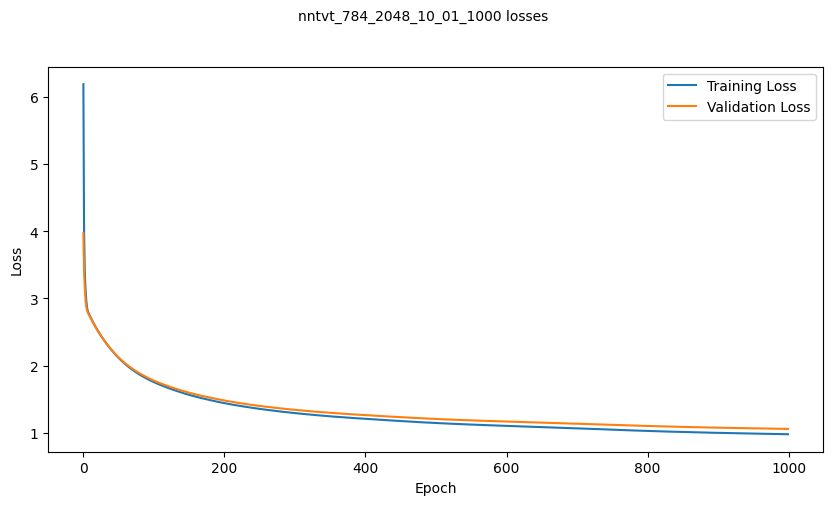

In [31]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(nntvt_784_2048_10_01_1000.train_losses, label="Training Loss")
plt.plot(nntvt_784_2048_10_01_1000.val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.suptitle("nntvt_784_2048_10_01_1000 losses", fontsize=10, y=0.995)
plt.show()

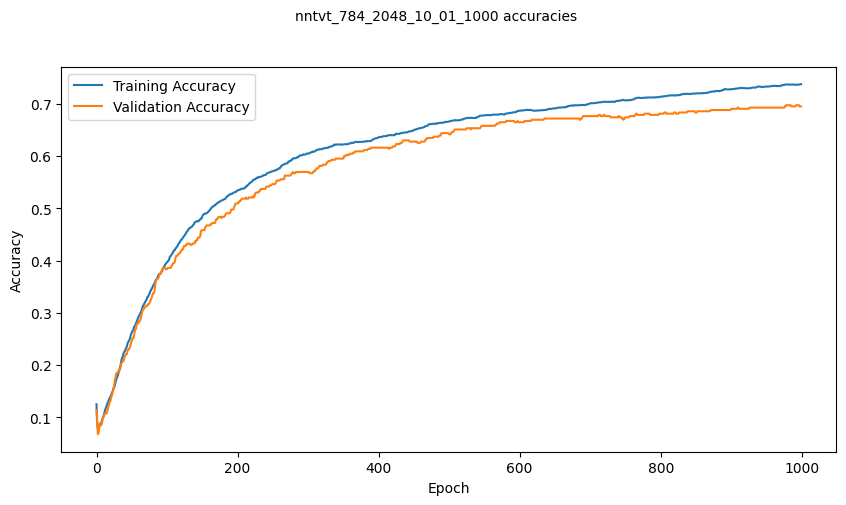

In [32]:
# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(nntvt_784_2048_10_01_1000.train_accuracies, label="Training Accuracy")
plt.plot(nntvt_784_2048_10_01_1000.val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.suptitle("nntvt_784_2048_10_01_1000 accuracies", fontsize=10, y=0.995)
plt.show()

In [33]:
# Make predictions on test data
predictions = nntvt_784_2048_10_01_1000.predict(X_test)
print("Predictions:", predictions)

# Calculate and display accuracy for the test set
accuracy = np.mean(predictions == np.argmax(y_test, axis=1))
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Predictions: [7 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 2 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0
 0 0 0 7 0 0 0 1 1 9 9 9 1 1 1 1 7 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 9 1
 9 1 1 1 1 1 1 1 1 9 1 1 1 1 9 2 3 2 2 5 2 2 2 3 3 2 5 3 2 5 2 2 2 2 2 3 3
 2 3 2 3 2 2 2 2 2 2 2 2 3 3 1 5 2 2 3 3 6 3 7 3 3 6 3 9 3 2 3 3 2 3 3 1 2
 3 2 0 6 0 3 3 5 3 7 3 6 3 3 2 2 3 0 3 8 6 0 3 3 0 9 2 4 5 7 4 4 4 4 5 9 5
 4 4 4 7 4 9 5 5 5 4 4 4 4 6 4 4 4 4 7 6 4 4 7 2 5 4 4 4 5 4 4 4 4 4 4 5 5
 5 5 5 5 5 3 2 5 2 5 5 5 5 5 5 2 2 5 5 5 9 5 5 5 7 5 6 5 1 5 6 3 5 5 5 5 5
 2 3 2 5 4 6 6 6 6 6 6 3 6 2 9 8 6 6 6 6 6 6 9 9 9 2 6 6 6 9 6 6 8 9 4 6 6
 6 6 6 6 6 6 6 6 6 6 7 6 7 7 7 7 6 7 7 4 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7
 7 7 7 7 2 7 7 7 7 0 6 7 7 7 7 7 0 7 7 8 8 8 8 8 8 8 6 8 8 8 9 8 8 6 8 8 8
 8 8 8 5 8 4 5 8 8 7 8 8 8 8 8 6 8 6 8 8 8 8 8 8 8 8 9 9 9 1 9 9 8 9 9 9 4
 4 9 9 4 9 9 9 9 9 9 6 5 9 9 9 8 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9]
Test Accuracy: 71.14%


Confusion Matrix (Test Set):
[[39  0  1  0  0  1  0  3  0  0]
 [ 0 36  0  0  0  1  0  1  0  6]
 [ 0  1 25 12  0  4  1  0  0  1]
 [ 5  1  7 20  1  1  4  2  1  2]
 [ 0  0  1  0 27  8  2  4  0  2]
 [ 0  1  6  3  1 29  2  1  0  1]
 [ 0  0  2  1  1  0 31  1  2  6]
 [ 3  0  1  0  2  0  2 36  0  0]
 [ 0  0  0  0  1  2  4  1 35  1]
 [ 0  1  0  0  3  1  2  0  2 35]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        44
           1       0.90      0.82      0.86        44
           2       0.58      0.57      0.57        44
           3       0.56      0.45      0.50        44
           4       0.75      0.61      0.67        44
           5       0.62      0.66      0.64        44
           6       0.65      0.70      0.67        44
           7       0.73      0.82      0.77        44
           8       0.88      0.80      0.83        44
           9       0.65      0.80      0.71        44

    accur

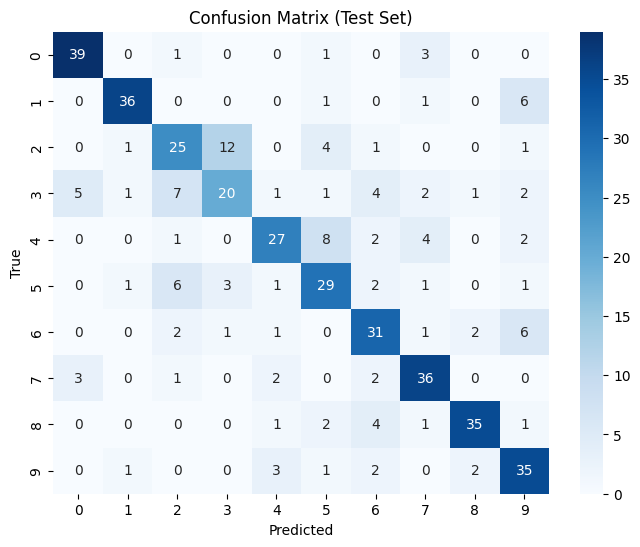

In [34]:
# Calculate confusion matrix and metrics for the test set
test_true_labels = np.argmax(y_test, axis=1)
test_confusion_matrix = confusion_matrix(test_true_labels, predictions)
test_classification_report = classification_report(test_true_labels, predictions, target_names=[str(label) for label in class_labels])

# Print and display the confusion matrix and metrics for the test set
print("Confusion Matrix (Test Set):")
print(test_confusion_matrix)

print("\nClassification Report (Test Set):")
print(test_classification_report)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()


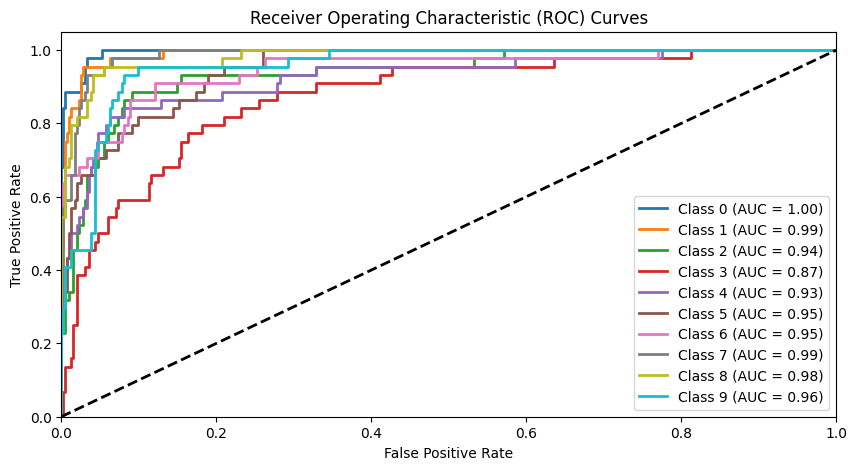

In [35]:
# Plot ROC curves
plt.figure(figsize=(10, 5))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(output_size):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], nntvt_784_2048_10_01_1000.forward(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

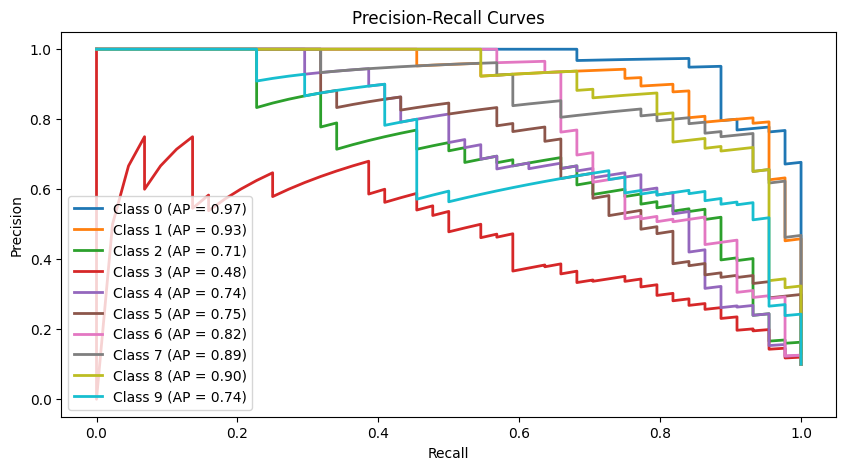

In [36]:
# Plot Precision-Recall curves
plt.figure(figsize=(10, 5))
precision = dict()
recall = dict()
average_precision = dict()
for i in range(output_size):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], nntvt_784_2048_10_01_1000.forward(X_test)[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], nntvt_784_2048_10_01_1000.forward(X_test)[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()


In [37]:
# Get the list of image names (assuming your filenames are available)
image_names = [filename for filename in os.listdir(test_dir) if filename.endswith('.jpg')]

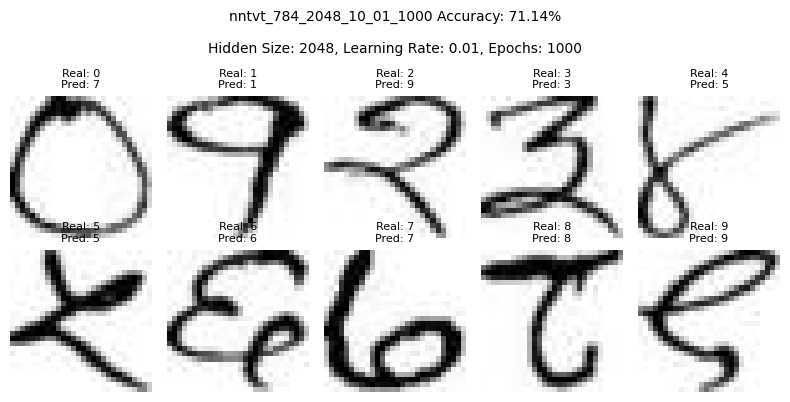

In [38]:
unique_labels = []

# Set the figure size and adjust the image size
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
for i, filename in enumerate(image_names):
    if len(unique_labels) == 10:
        break

    image = X_test[i].reshape(28, 28)
    label = np.argmax(y_test[i])  # Convert one-hot encoding to label
    prediction = predictions[i]

    if label not in unique_labels:
        plt.subplot(2, 5, len(unique_labels) + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Real: {label}\nPred: {prediction}", fontsize=8)
        plt.axis('off')
        unique_labels.append(label)

# Add an overall title with accuracy
accuracy_text = f"nntvt_784_2048_10_01_1000 Accuracy: {accuracy * 100:.2f}%\n\nHidden Size: {hidden_size}, Learning Rate: {learning_rate}, Epochs: {epochs}"
plt.suptitle(accuracy_text, fontsize=10, y=0.995)  # Adjust fontsize and position as needed
plt.tight_layout()
plt.show()


### Using dropout model (weights + bias + ReLU + Softmax + Train, Val & Test + Metrics + Dropout) Best: 48.18%
*   input_size = 784  # 28x28 = 784 pixels
*   output_size = 10  
*   hidden_size = 2048
*   learning_rate = 0.01
*   dropout_prob = 0.5


1.   Initial Experiment (100 epoch + 0.5)
2.   Improved Experiment (1000 epochs + 0.5) best
2.   Improved Experiment (1000 epochs + 0.25)

#### Intial Model NeuralNetwork_TVT_mertics_dropout: Accuracy: 18.18%
*   input_size = 784  # 28x28 = 784 pixels
*   output_size = 10  # 10 classes
*   hidden_size = 2048 # 512 # 1024
*   learning_rate = 0.01 # 0.01 seems good, 0.1 is not the best
*   epochs = 100
*   dropout_prob = 0.5

##### Initialise and Train Model

###### Hyperparameters

In [40]:
# Create and train the neural network
input_size = 784  # 28x28 = 784 pixels
output_size = 10  # 10 classes

# these are the hyperparmeters
hidden_size = 2048 # 512 # 1024
learning_rate = 0.01 # 0.01 seems good, 0.1 is not the best
epochs = 100
dropout_prob = 0.5

In [41]:
nntvt_784_2048_10_01_100_do = NeuralNetwork_TVT_mertics_dropout(input_size, hidden_size, output_size, learning_rate, dropout_prob)

In [42]:
nntvt_784_2048_10_01_100_do.train(X_train, y_train, X_val, y_val, epochs)

Epoch 1/100
Train Loss: 2.3027, Train Accuracy: 11.99%
Validation Loss: 2.3027, Validation Accuracy: 12.09%
Epoch 2/100
Train Loss: 2.3027, Train Accuracy: 11.99%
Validation Loss: 2.3027, Validation Accuracy: 12.09%
Epoch 3/100
Train Loss: 2.3027, Train Accuracy: 12.04%
Validation Loss: 2.3027, Validation Accuracy: 12.33%
Epoch 4/100
Train Loss: 2.3027, Train Accuracy: 12.09%
Validation Loss: 2.3027, Validation Accuracy: 12.33%
Epoch 5/100
Train Loss: 2.3026, Train Accuracy: 12.09%
Validation Loss: 2.3027, Validation Accuracy: 12.79%
Epoch 6/100
Train Loss: 2.3027, Train Accuracy: 12.19%
Validation Loss: 2.3027, Validation Accuracy: 12.79%
Epoch 7/100
Train Loss: 2.3026, Train Accuracy: 12.24%
Validation Loss: 2.3027, Validation Accuracy: 12.79%
Epoch 8/100
Train Loss: 2.3027, Train Accuracy: 12.24%
Validation Loss: 2.3027, Validation Accuracy: 13.02%
Epoch 9/100
Train Loss: 2.3026, Train Accuracy: 12.24%
Validation Loss: 2.3026, Validation Accuracy: 13.02%
Epoch 10/100
Train Loss: 2.3

##### Predict using trained model

In [43]:
# Make predictions on new data
predictions = nntvt_784_2048_10_01_100_do.predict(X_test)
print("Predictions:", predictions)

Predictions: [2 2 0 0 9 0 3 6 0 0 6 0 3 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 6 0 2 2 3 0 2 0
 6 0 9 6 9 3 0 3 2 2 1 1 2 3 2 3 3 2 2 2 3 3 2 3 3 1 2 3 3 3 3 3 3 9 3 1 3
 3 2 1 2 1 3 2 2 3 2 2 3 2 2 2 3 3 3 3 6 3 3 2 3 3 3 6 2 3 6 2 3 3 3 3 3 2
 3 1 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 9 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 1 3 0 2 0 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 6 2 0 0 2 1 2 2 2 2
 3 2 0 2 0 2 3 1 2 2 1 2 9 2 1 2 1 6 3 3 1 0 2 2 3 2 2 3 3 1 2 3 3 3 0 2 2
 3 3 3 3 3 2 3 3 3 3 3 2 2 3 3 3 2 2 2 3 2 3 3 3 1 3 2 2 3 2 1 2 3 3 3 2 2
 2 2 2 2 3 2 2 6 3 2 3 3 2 3 2 3 3 3 3 3 2 3 3 2 2 3 6 2 1 1 2 1 3 3 3 2 3
 3 6 3 6 6 3 2 2 3 6 2 3 0 3 0 3 3 2 0 3 6 2 0 2 0 2 0 2 2 2 0 0 0 0 2 3 0
 1 3 3 2 0 2 2 3 3 2 3 0 2 2 3 2 2 0 0 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 1
 1 3 1 1 3 0 1 3 3 0 3 3 3 0 3 3 3 3 0 3 3 3 3 3 3 3 3 3 2 1 3 2 1 3 9 3 3
 0 0 3 2 1 1 3 3 1 3 3 3 3 1 0 3 3 2 9 3 3 3 1 3 3 1 3 2 3 2 3 2 3]


##### Visualisation

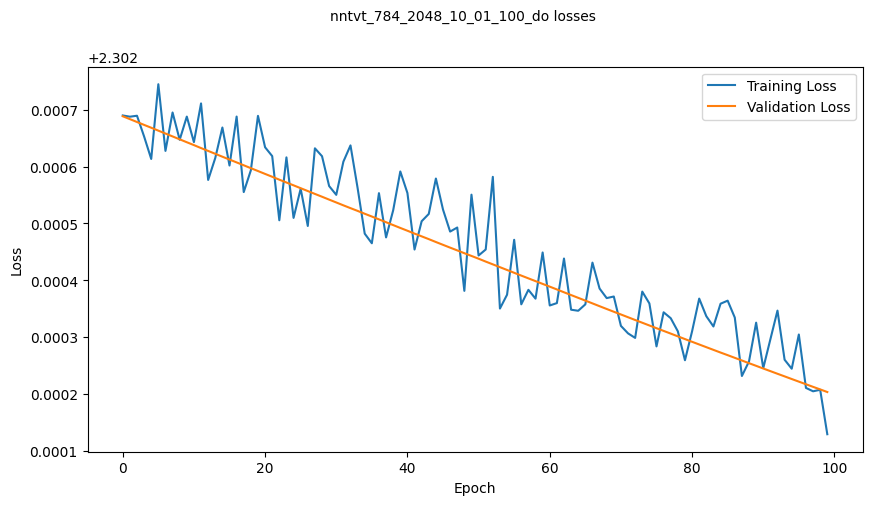

In [44]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(nntvt_784_2048_10_01_100_do.train_losses, label="Training Loss")
plt.plot(nntvt_784_2048_10_01_100_do.val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.suptitle("nntvt_784_2048_10_01_100_do losses", fontsize=10, y=0.995)
plt.show()

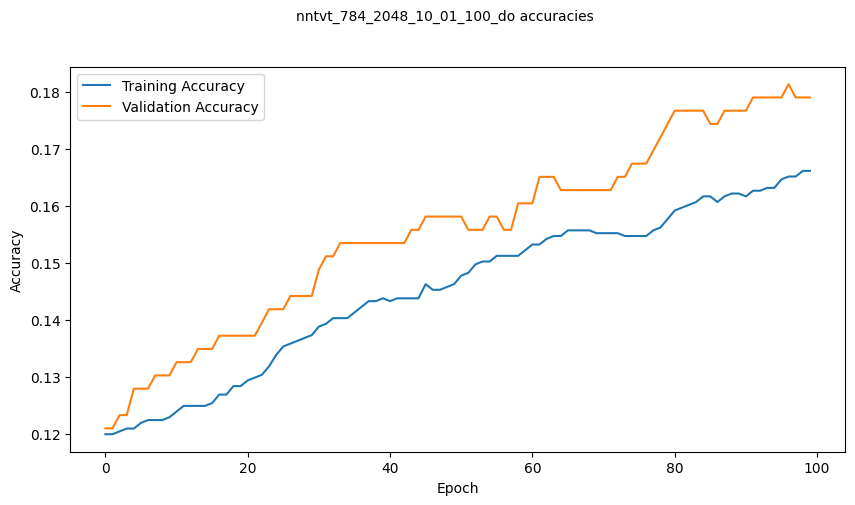

In [45]:
# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(nntvt_784_2048_10_01_100_do.train_accuracies, label="Training Accuracy")
plt.plot(nntvt_784_2048_10_01_100_do.val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.suptitle("nntvt_784_2048_10_01_100_do accuracies", fontsize=10, y=0.995)
plt.show()

In [46]:
# Make predictions on test data
predictions = nntvt_784_2048_10_01_100_do.predict(X_test)
print("Predictions:", predictions)

# Calculate and display accuracy for the test set
accuracy = np.mean(predictions == np.argmax(y_test, axis=1))
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Predictions: [2 2 0 0 9 0 3 6 0 0 6 0 3 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 6 0 2 2 3 0 2 0
 6 0 9 6 9 3 0 3 2 2 1 1 2 3 2 3 3 2 2 2 3 3 2 3 3 1 2 3 3 3 3 3 3 9 3 1 3
 3 2 1 2 1 3 2 2 3 2 2 3 2 2 2 3 3 3 3 6 3 3 2 3 3 3 6 2 3 6 2 3 3 3 3 3 2
 3 1 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 9 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 1 3 0 2 0 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 6 2 0 0 2 1 2 2 2 2
 3 2 0 2 0 2 3 1 2 2 1 2 9 2 1 2 1 6 3 3 1 0 2 2 3 2 2 3 3 1 2 3 3 3 0 2 2
 3 3 3 3 3 2 3 3 3 3 3 2 2 3 3 3 2 2 2 3 2 3 3 3 1 3 2 2 3 2 1 2 3 3 3 2 2
 2 2 2 2 3 2 2 6 3 2 3 3 2 3 2 3 3 3 3 3 2 3 3 2 2 3 6 2 1 1 2 1 3 3 3 2 3
 3 6 3 6 6 3 2 2 3 6 2 3 0 3 0 3 3 2 0 3 6 2 0 2 0 2 0 2 2 2 0 0 0 0 2 3 0
 1 3 3 2 0 2 2 3 3 2 3 0 2 2 3 2 2 0 0 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 1
 1 3 1 1 3 0 1 3 3 0 3 3 3 0 3 3 3 3 0 3 3 3 3 3 3 3 3 3 2 1 3 2 1 3 9 3 3
 0 0 3 2 1 1 3 3 1 3 3 3 3 1 0 3 3 2 9 3 3 3 1 3 3 1 3 2 3 2 3 2 3]
Test Accuracy: 18.18%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix (Test Set):
[[26  0  5  4  0  0  5  0  0  4]
 [ 0  6 17 20  0  0  0  0  0  1]
 [ 0  1  6 33  0  0  3  0  0  1]
 [ 2  1  6 34  0  0  1  0  0  0]
 [ 6  7 19 10  0  0  1  0  0  1]
 [ 0  2 19 23  0  0  0  0  0  0]
 [ 0  3 14 21  0  0  6  0  0  0]
 [15  1 16 11  0  0  1  0  0  0]
 [ 5  5  0 34  0  0  0  0  0  0]
 [ 3  8  7 24  0  0  0  0  0  2]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.46      0.59      0.51        44
           1       0.18      0.14      0.15        44
           2       0.06      0.14      0.08        44
           3       0.16      0.77      0.26        44
           4       0.00      0.00      0.00        44
           5       0.00      0.00      0.00        44
           6       0.35      0.14      0.20        44
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00        44
           9       0.22      0.05      0.08        44

    accur

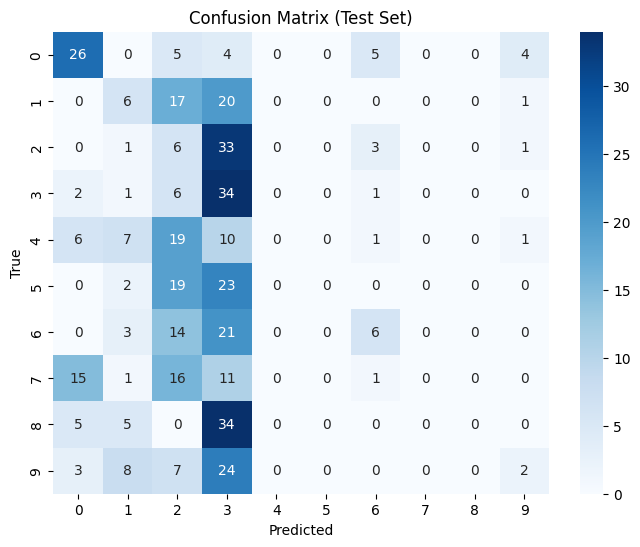

In [47]:
# Calculate confusion matrix and metrics for the test set
test_true_labels = np.argmax(y_test, axis=1)
test_confusion_matrix = confusion_matrix(test_true_labels, predictions)
test_classification_report = classification_report(test_true_labels, predictions, target_names=[str(label) for label in class_labels])

# Print and display the confusion matrix and metrics for the test set
print("Confusion Matrix (Test Set):")
print(test_confusion_matrix)

print("\nClassification Report (Test Set):")
print(test_classification_report)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()


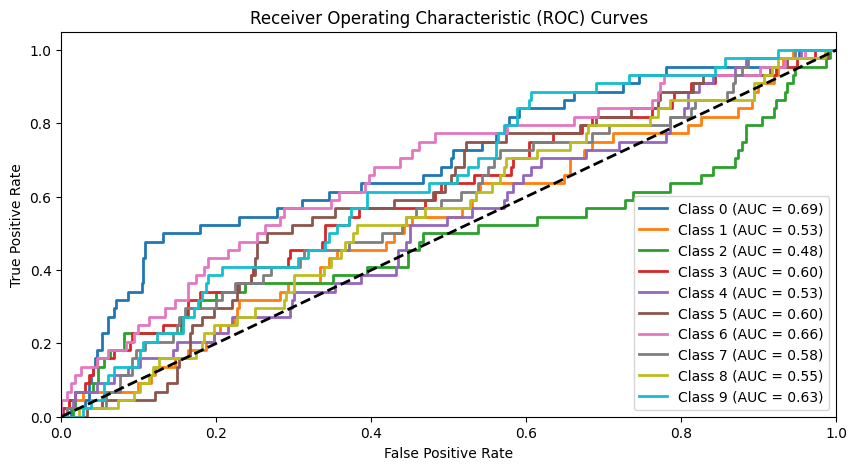

In [48]:
# Plot ROC curves
plt.figure(figsize=(10, 5))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(output_size):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], nntvt_784_2048_10_01_100_do.forward(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

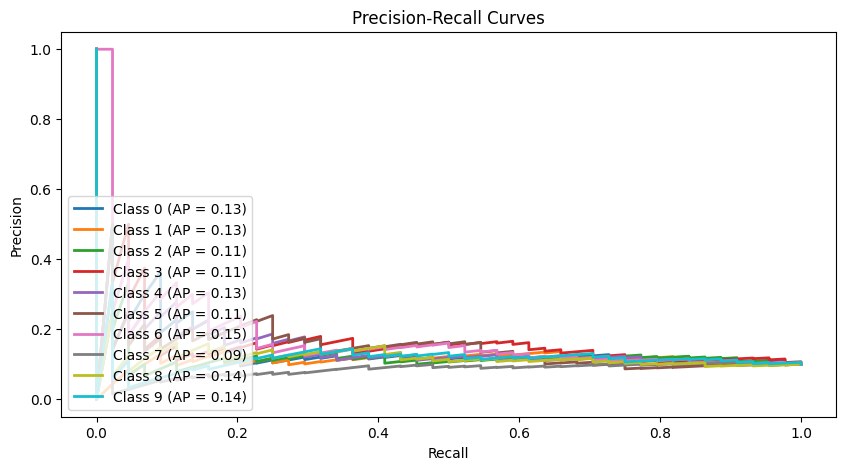

In [49]:
# Plot Precision-Recall curves
plt.figure(figsize=(10, 5))
precision = dict()
recall = dict()
average_precision = dict()
for i in range(output_size):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], nntvt_784_2048_10_01_100_do.forward(X_test)[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], nntvt_784_2048_10_01_100_do.forward(X_test)[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()


In [50]:
# Get the list of image names (assuming your filenames are available)
image_names = [filename for filename in os.listdir(test_dir) if filename.endswith('.jpg')]

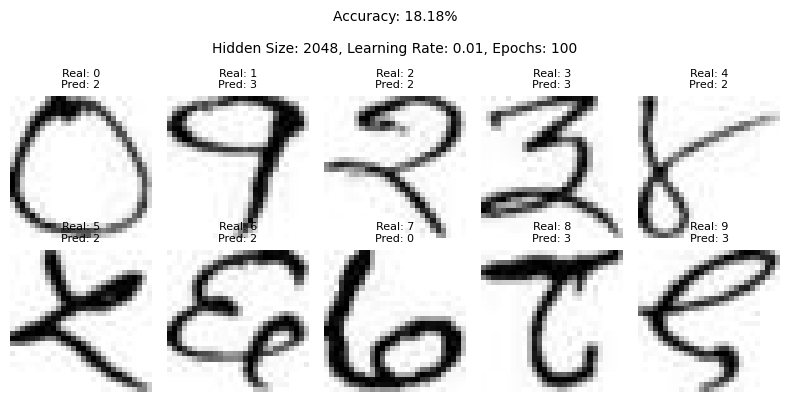

In [51]:
unique_labels = []

# Set the figure size and adjust the image size
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
for i, filename in enumerate(image_names):
    if len(unique_labels) == 10:
        break

    image = X_test[i].reshape(28, 28)
    label = np.argmax(y_test[i])  # Convert one-hot encoding to label
    prediction = predictions[i]

    if label not in unique_labels:
        plt.subplot(2, 5, len(unique_labels) + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Real: {label}\nPred: {prediction}", fontsize=8)
        plt.axis('off')
        unique_labels.append(label)

# Add an overall title with accuracy
accuracy_text = f"Accuracy: {accuracy * 100:.2f}%\n\nHidden Size: {hidden_size}, Learning Rate: {learning_rate}, Epochs: {epochs}"
plt.suptitle(accuracy_text, fontsize=10, y=0.995)  # Adjust fontsize and position as needed
plt.tight_layout()
plt.show()


#### Updated Model NeuralNetwork_TVT_mertics_dropout 1000 epoch dropout 0.5 - Accuracy: 48.18%
*   input_size = 784  # 28x28 = 784 pixels
*   output_size = 10  # 10 classes
*   hidden_size = 2048 # 512 # 1024
*   learning_rate = 0.01 # 0.01 seems good, 0.1 is not the best
*   epochs = 1000
*   dropout_prob = 0.5

##### Initialise and Train Model

###### Hyperparameters

In [52]:
# Create and train the neural network
input_size = 784  # 28x28 = 784 pixels
output_size = 10  # 10 classes

# these are the hyperparmeters
hidden_size = 2048 # 512 # 1024
learning_rate = 0.01 # 0.01 seems good, 0.1 is not the best
epochs = 1000
dropout_prob = 0.5

In [53]:
nntvt_784_2048_10_01_1000_do = NeuralNetwork_TVT_mertics_dropout(input_size, hidden_size, output_size, learning_rate, dropout_prob)

In [54]:
nntvt_784_2048_10_01_1000_do.train(X_train, y_train, X_val, y_val, epochs)

Epoch 1/1000
Train Loss: 2.3025, Train Accuracy: 14.43%
Validation Loss: 2.3024, Validation Accuracy: 14.42%
Epoch 2/1000
Train Loss: 2.3025, Train Accuracy: 14.48%
Validation Loss: 2.3024, Validation Accuracy: 14.65%
Epoch 3/1000
Train Loss: 2.3024, Train Accuracy: 14.58%
Validation Loss: 2.3024, Validation Accuracy: 14.65%
Epoch 4/1000
Train Loss: 2.3025, Train Accuracy: 14.53%
Validation Loss: 2.3024, Validation Accuracy: 14.65%
Epoch 5/1000
Train Loss: 2.3024, Train Accuracy: 14.63%
Validation Loss: 2.3024, Validation Accuracy: 14.65%
Epoch 6/1000
Train Loss: 2.3025, Train Accuracy: 14.53%
Validation Loss: 2.3024, Validation Accuracy: 14.65%
Epoch 7/1000
Train Loss: 2.3024, Train Accuracy: 14.53%
Validation Loss: 2.3024, Validation Accuracy: 14.65%
Epoch 8/1000
Train Loss: 2.3024, Train Accuracy: 14.58%
Validation Loss: 2.3024, Validation Accuracy: 14.65%
Epoch 9/1000
Train Loss: 2.3024, Train Accuracy: 14.63%
Validation Loss: 2.3024, Validation Accuracy: 14.65%
Epoch 10/1000
Train

##### Predict using trained model

In [55]:
# Make predictions on new data
predictions = nntvt_784_2048_10_01_1000_do.predict(X_test)
print("Predictions:", predictions)

Predictions: [8 0 0 0 0 0 8 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 8 8 0 0 0
 0 0 8 8 8 8 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 8 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 8 5 3 3 8 3 2 2 2 1 5 3 3 8 8 3 3 5 5 5 5 5 8
 3 3 5 5 3 5 3 8 5 3 2 3 1 3 1 3 5 3 2 2 5 3 3 8 3 3 3 8 3 8 3 3 3 3 3 1 3
 3 3 0 3 3 5 3 3 3 3 3 3 6 3 3 8 3 3 3 3 3 2 3 3 3 6 8 3 8 3 5 3 8 4 8 3 6
 8 1 3 9 3 3 8 3 3 8 3 5 8 3 3 3 5 8 8 8 3 3 3 5 8 3 5 8 8 5 3 5 8 3 8 5 5
 3 3 3 3 5 3 3 8 5 8 3 3 2 3 5 5 8 3 8 5 8 3 3 3 3 3 3 3 8 5 3 3 5 5 3 3 8
 5 5 8 3 3 6 8 6 3 6 6 8 1 8 6 3 3 3 3 8 8 6 8 6 8 3 6 3 3 8 6 6 6 8 6 6 6
 6 3 1 6 6 3 8 3 6 6 8 8 0 0 3 8 3 7 0 8 8 0 3 8 0 8 8 0 7 3 7 0 6 8 7 8 8
 8 3 1 8 8 8 3 3 0 3 1 6 0 8 3 8 0 0 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 9 8 8 9 8 8 9 8 9
 8 8 8 1 9 8 8 8 8 9 8 8 9 1 1 8 1 9 9 9 8 1 9 9 8 9 8 1 9 9 1 9 8]


##### Visualisation

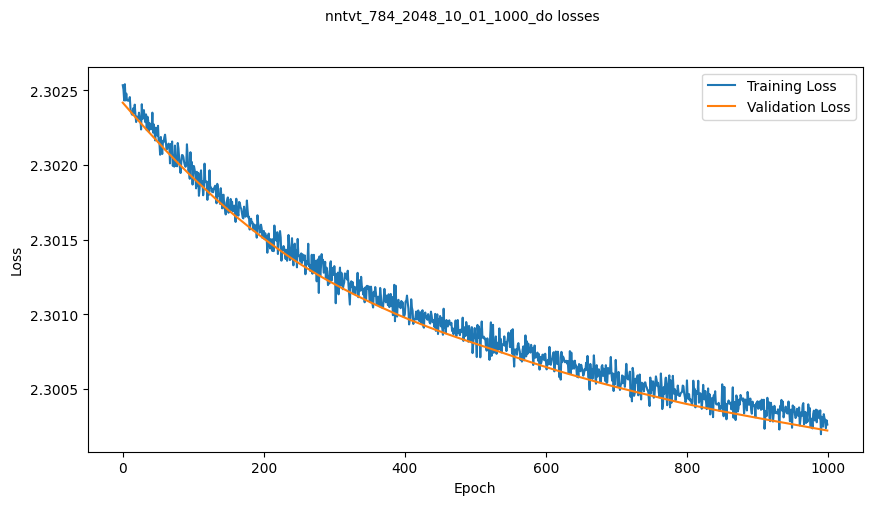

In [56]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(nntvt_784_2048_10_01_1000_do.train_losses, label="Training Loss")
plt.plot(nntvt_784_2048_10_01_1000_do.val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.suptitle("nntvt_784_2048_10_01_1000_do losses", fontsize=10, y=0.995)
plt.show()

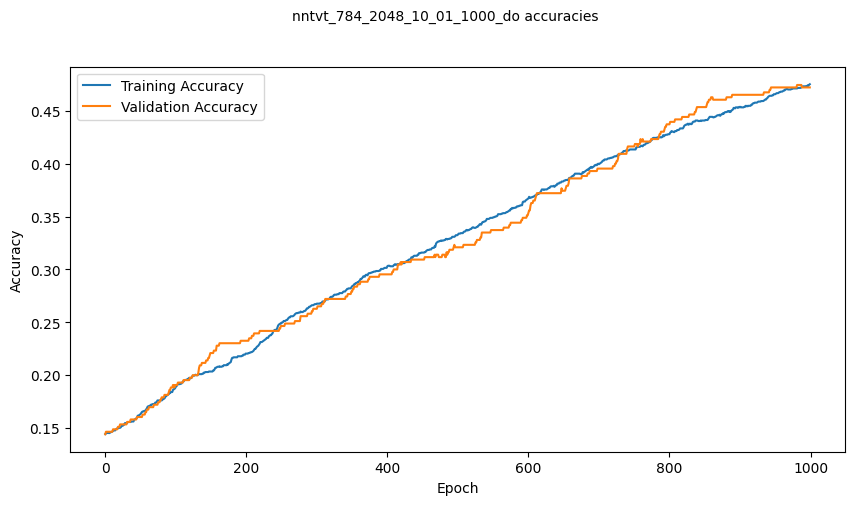

In [57]:
# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(nntvt_784_2048_10_01_1000_do.train_accuracies, label="Training Accuracy")
plt.plot(nntvt_784_2048_10_01_1000_do.val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.suptitle("nntvt_784_2048_10_01_1000_do accuracies", fontsize=10, y=0.995)
plt.show()

In [58]:
# Make predictions on test data
predictions = nntvt_784_2048_10_01_1000_do.predict(X_test)
print("Predictions:", predictions)

# Calculate and display accuracy for the test set
accuracy = np.mean(predictions == np.argmax(y_test, axis=1))
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Predictions: [8 0 0 0 0 0 8 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 8 8 0 0 0
 0 0 8 8 8 8 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 8 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 8 5 3 3 8 3 2 2 2 1 5 3 3 8 8 3 3 5 5 5 5 5 8
 3 3 5 5 3 5 3 8 5 3 2 3 1 3 1 3 5 3 2 2 5 3 3 8 3 3 3 8 3 8 3 3 3 3 3 1 3
 3 3 0 3 3 5 3 3 3 3 3 3 6 3 3 8 3 3 3 3 3 2 3 3 3 6 8 3 8 3 5 3 8 4 8 3 6
 8 1 3 9 3 3 8 3 3 8 3 5 8 3 3 3 5 8 8 8 3 3 3 5 8 3 5 8 8 5 3 5 8 3 8 5 5
 3 3 3 3 5 3 3 8 5 8 3 3 2 3 5 5 8 3 8 5 8 3 3 3 3 3 3 3 8 5 3 3 5 5 3 3 8
 5 5 8 3 3 6 8 6 3 6 6 8 1 8 6 3 3 3 3 8 8 6 8 6 8 3 6 3 3 8 6 6 6 8 6 6 6
 6 3 1 6 6 3 8 3 6 6 8 8 0 0 3 8 3 7 0 8 8 0 3 8 0 8 8 0 7 3 7 0 6 8 7 8 8
 8 3 1 8 8 8 3 3 0 3 1 6 0 8 3 8 0 0 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 9 8 8 9 8 8 9 8 9
 8 8 8 1 9 8 8 8 8 9 8 8 9 1 1 8 1 9 9 9 8 1 9 9 8 9 8 1 9 9 1 9 8]
Test Accuracy: 48.18%


Confusion Matrix (Test Set):
[[34  0  0  1  0  0  0  0  9  0]
 [ 0 43  0  0  0  0  0  0  1  0]
 [ 0  3  6 16  0 13  0  0  6  0]
 [ 1  1  1 33  0  1  2  0  5  0]
 [ 0  1  0 18  1  7  1  0 15  1]
 [ 0  0  1 23  0 12  0  0  8  0]
 [ 0  2  0 11  0  0 19  0 12  0]
 [11  2  0 10  0  0  2  4 15  0]
 [ 0  0  0  1  0  0  0  0 43  0]
 [ 0  7  0  0  0  0  0  0 20 17]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.74      0.77      0.76        44
           1       0.73      0.98      0.83        44
           2       0.75      0.14      0.23        44
           3       0.29      0.75      0.42        44
           4       1.00      0.02      0.04        44
           5       0.36      0.27      0.31        44
           6       0.79      0.43      0.56        44
           7       1.00      0.09      0.17        44
           8       0.32      0.98      0.48        44
           9       0.94      0.39      0.55        44

    accur

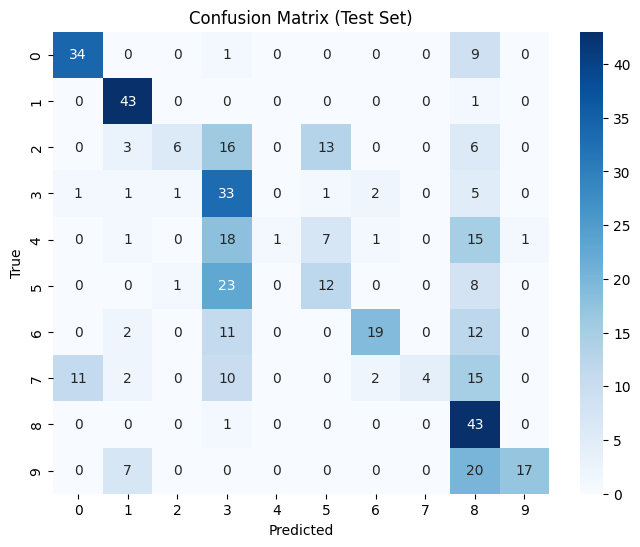

In [59]:
# Calculate confusion matrix and metrics for the test set
test_true_labels = np.argmax(y_test, axis=1)
test_confusion_matrix = confusion_matrix(test_true_labels, predictions)
test_classification_report = classification_report(test_true_labels, predictions, target_names=[str(label) for label in class_labels])

# Print and display the confusion matrix and metrics for the test set
print("Confusion Matrix (Test Set):")
print(test_confusion_matrix)

print("\nClassification Report (Test Set):")
print(test_classification_report)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()


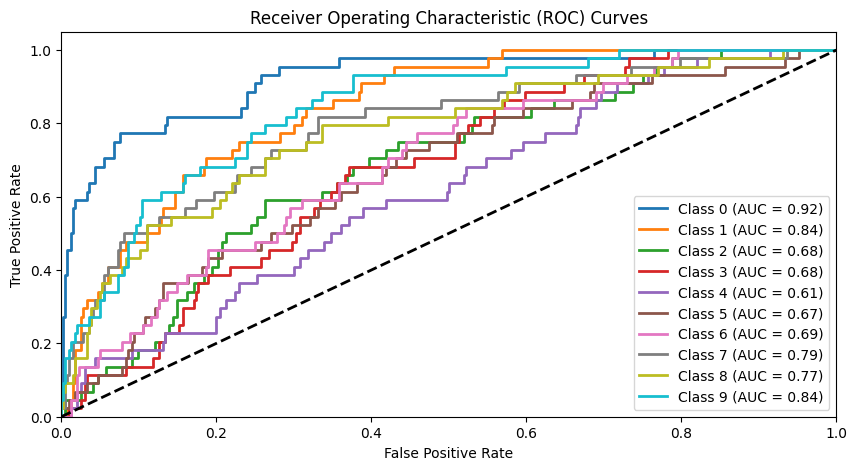

In [60]:
# Plot ROC curves
plt.figure(figsize=(10, 5))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(output_size):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], nntvt_784_2048_10_01_1000_do.forward(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

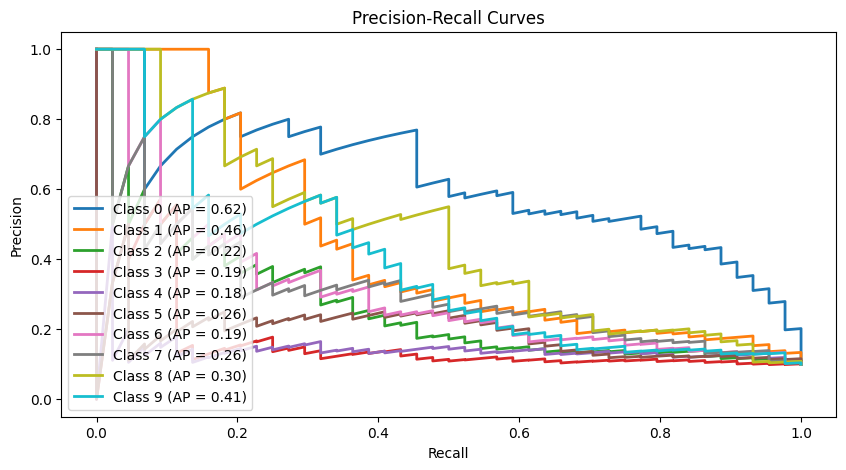

In [61]:
# Plot Precision-Recall curves
plt.figure(figsize=(10, 5))
precision = dict()
recall = dict()
average_precision = dict()
for i in range(output_size):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], nntvt_784_2048_10_01_1000_do.forward(X_test)[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], nntvt_784_2048_10_01_1000_do.forward(X_test)[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()


In [62]:
# Get the list of image names (assuming your filenames are available)
image_names = [filename for filename in os.listdir(test_dir) if filename.endswith('.jpg')]

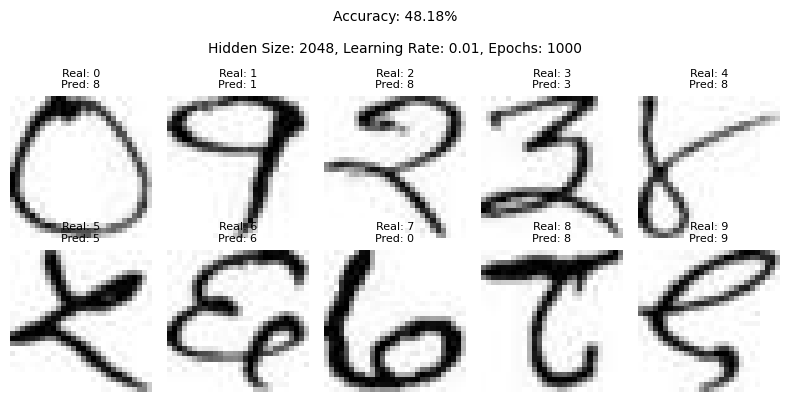

In [63]:
unique_labels = []

# Set the figure size and adjust the image size
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
for i, filename in enumerate(image_names):
    if len(unique_labels) == 10:
        break

    image = X_test[i].reshape(28, 28)
    label = np.argmax(y_test[i])  # Convert one-hot encoding to label
    prediction = predictions[i]

    if label not in unique_labels:
        plt.subplot(2, 5, len(unique_labels) + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Real: {label}\nPred: {prediction}", fontsize=8)
        plt.axis('off')
        unique_labels.append(label)

# Add an overall title with accuracy
accuracy_text = f"Accuracy: {accuracy * 100:.2f}%\n\nHidden Size: {hidden_size}, Learning Rate: {learning_rate}, Epochs: {epochs}"
plt.suptitle(accuracy_text, fontsize=10, y=0.995)  # Adjust fontsize and position as needed
plt.tight_layout()
plt.show()


#### Updated Model NeuralNetwork_TVT_mertics_dropout 1000 epoch dropout 0.25 - Accuracy: 34.09%
*   input_size = 784  # 28x28 = 784 pixels
*   output_size = 10  # 10 classes
*   hidden_size = 2048 # 512 # 1024
*   learning_rate = 0.01 # 0.01 seems good, 0.1 is not the best
*   epochs = 1000
*   dropout_prob = 0.25

##### Initialise and Train Model

###### Hyperparameters

In [64]:
# Create and train the neural network
input_size = 784  # 28x28 = 784 pixels
output_size = 10  # 10 classes

# these are the hyperparmeters
hidden_size = 2048 # 512 # 1024
learning_rate = 0.01 # 0.01 seems good, 0.1 is not the best
epochs = 1000
dropout_prob = 0.25

In [65]:
nntvt_784_2048_10_01_1000_do_25 = NeuralNetwork_TVT_mertics_dropout(input_size, hidden_size, output_size, learning_rate, dropout_prob)

In [66]:
nntvt_784_2048_10_01_1000_do_25.train(X_train, y_train, X_val, y_val, epochs)

Epoch 1/1000
Train Loss: 2.3026, Train Accuracy: 9.55%
Validation Loss: 2.3026, Validation Accuracy: 8.60%
Epoch 2/1000
Train Loss: 2.3026, Train Accuracy: 9.55%
Validation Loss: 2.3026, Validation Accuracy: 8.60%
Epoch 3/1000
Train Loss: 2.3026, Train Accuracy: 9.70%
Validation Loss: 2.3026, Validation Accuracy: 8.60%
Epoch 4/1000
Train Loss: 2.3026, Train Accuracy: 9.70%
Validation Loss: 2.3026, Validation Accuracy: 8.84%
Epoch 5/1000
Train Loss: 2.3025, Train Accuracy: 9.70%
Validation Loss: 2.3026, Validation Accuracy: 9.07%
Epoch 6/1000
Train Loss: 2.3026, Train Accuracy: 9.70%
Validation Loss: 2.3026, Validation Accuracy: 9.07%
Epoch 7/1000
Train Loss: 2.3026, Train Accuracy: 9.75%
Validation Loss: 2.3026, Validation Accuracy: 9.07%
Epoch 8/1000
Train Loss: 2.3026, Train Accuracy: 9.85%
Validation Loss: 2.3026, Validation Accuracy: 9.07%
Epoch 9/1000
Train Loss: 2.3026, Train Accuracy: 9.85%
Validation Loss: 2.3026, Validation Accuracy: 9.07%
Epoch 10/1000
Train Loss: 2.3026, Tra

##### Predict using trained model

In [67]:
# Make predictions on new data
predictions = nntvt_784_2048_10_01_1000_do_25.predict(X_test)
print("Predictions:", predictions)

Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0
 0 0 0 0 9 0 0 5 9 9 5 5 5 5 9 9 5 9 5 5 9 5 4 5 5 9 5 9 9 5 9 5 9 9 9 9 9
 5 9 9 5 9 5 9 9 9 5 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5
 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 7 5 5 5
 5 9 5 9 5 4 5 5 5 5 4 5 5 9 5 5 5 9 5 8 5 7 5 4 5 7 4 5 5 5 5 4 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 7 5 5 5 5 4 5 5 5 5 5
 4 5 5 5 5 9 6 6 5 9 5 5 5 9 5 6 9 5 9 5 5 9 5 9 5 9 6 9 9 9 9 9 7 9 9 9 6
 5 9 9 6 9 9 5 9 9 9 7 5 7 7 7 8 7 7 7 5 7 7 7 7 7 7 7 0 7 5 7 7 7 9 7 7 7
 9 7 7 9 5 6 7 5 0 7 5 7 7 7 7 0 7 7 7 8 0 5 5 5 5 8 4 5 0 9 9 0 0 4 4 9 5
 8 6 8 5 5 8 5 5 5 0 8 8 9 0 0 5 4 4 8 9 8 9 9 9 8 4 9 5 5 9 5 9 9 5 9 5 5
 5 5 6 5 5 5 5 9 5 9 5 5 9 9 9 5 9 0 5 0 9 9 5 9 5 4 5 9 9 0 5 9 9]


##### Visualisation

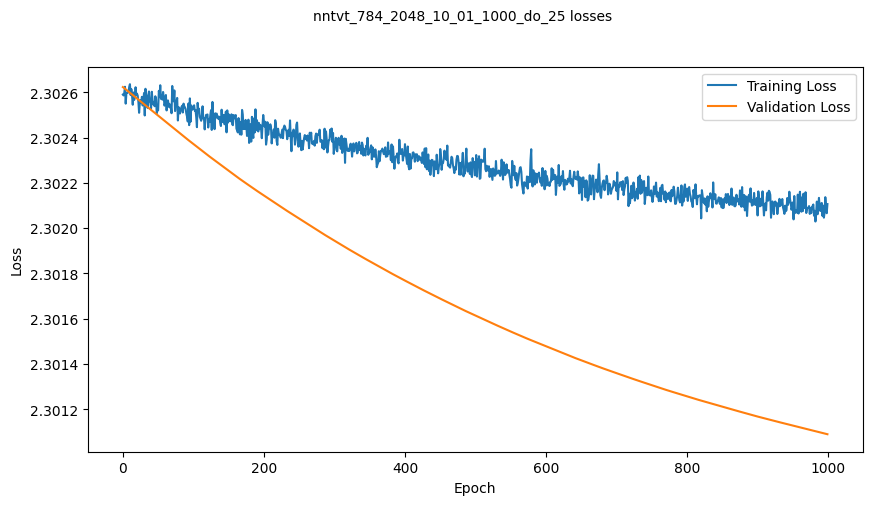

In [68]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(nntvt_784_2048_10_01_1000_do_25.train_losses, label="Training Loss")
plt.plot(nntvt_784_2048_10_01_1000_do_25.val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.suptitle("nntvt_784_2048_10_01_1000_do_25 losses", fontsize=10, y=0.995)
plt.show()

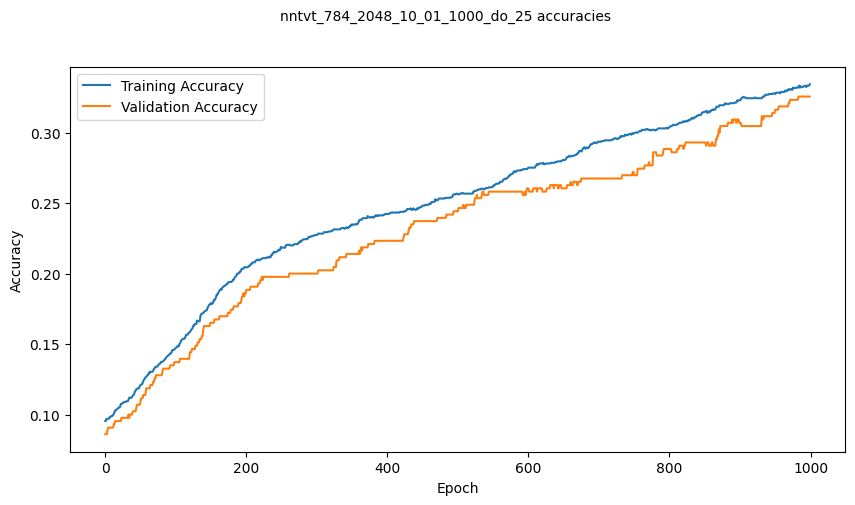

In [69]:
# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(nntvt_784_2048_10_01_1000_do_25.train_accuracies, label="Training Accuracy")
plt.plot(nntvt_784_2048_10_01_1000_do_25.val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.suptitle("nntvt_784_2048_10_01_1000_do_25 accuracies", fontsize=10, y=0.995)
plt.show()

In [70]:
# Make predictions on test data
predictions = nntvt_784_2048_10_01_1000_do_25.predict(X_test)
print("Predictions:", predictions)

# Calculate and display accuracy for the test set
accuracy = np.mean(predictions == np.argmax(y_test, axis=1))
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0
 0 0 0 0 9 0 0 5 9 9 5 5 5 5 9 9 5 9 5 5 9 5 4 5 5 9 5 9 9 5 9 5 9 9 9 9 9
 5 9 9 5 9 5 9 9 9 5 5 5 9 9 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 5 5 5
 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 7 5 5 5
 5 9 5 9 5 4 5 5 5 5 4 5 5 9 5 5 5 9 5 8 5 7 5 4 5 7 4 5 5 5 5 4 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 9 5 5 5 5 5 5 5 5 5 5 5 5 5 5 9 5 7 5 5 5 5 4 5 5 5 5 5
 4 5 5 5 5 9 6 6 5 9 5 5 5 9 5 6 9 5 9 5 5 9 5 9 5 9 6 9 9 9 9 9 7 9 9 9 6
 5 9 9 6 9 9 5 9 9 9 7 5 7 7 7 8 7 7 7 5 7 7 7 7 7 7 7 0 7 5 7 7 7 9 7 7 7
 9 7 7 9 5 6 7 5 0 7 5 7 7 7 7 0 7 7 7 8 0 5 5 5 5 8 4 5 0 9 9 0 0 4 4 9 5
 8 6 8 5 5 8 5 5 5 0 8 8 9 0 0 5 4 4 8 9 8 9 9 9 8 4 9 5 5 9 5 9 9 5 9 5 5
 5 5 6 5 5 5 5 9 5 9 5 5 9 9 9 5 9 0 5 0 9 9 5 9 5 4 5 9 9 0 5 9 9]
Test Accuracy: 34.09%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix (Test Set):
[[41  0  0  0  0  0  1  0  0  2]
 [ 0  0  0  0  1 20  0  0  0 23]
 [ 0  0  0  0  0 42  0  0  0  2]
 [ 0  0  0  0  2 41  0  0  0  1]
 [ 0  0  0  0  5 31  0  3  1  4]
 [ 0  0  0  0  2 39  0  1  0  2]
 [ 0  0  0  0  0 13  6  2  0 23]
 [ 3  0  0  0  0  5  1 31  1  3]
 [ 7  0  0  0  6 12  1  0 10  8]
 [ 3  0  0  0  1 21  1  0  0 18]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        44
           1       0.00      0.00      0.00        44
           2       0.00      0.00      0.00        44
           3       0.00      0.00      0.00        44
           4       0.29      0.11      0.16        44
           5       0.17      0.89      0.29        44
           6       0.60      0.14      0.22        44
           7       0.84      0.70      0.77        44
           8       0.83      0.23      0.36        44
           9       0.21      0.41      0.28        44

    accur

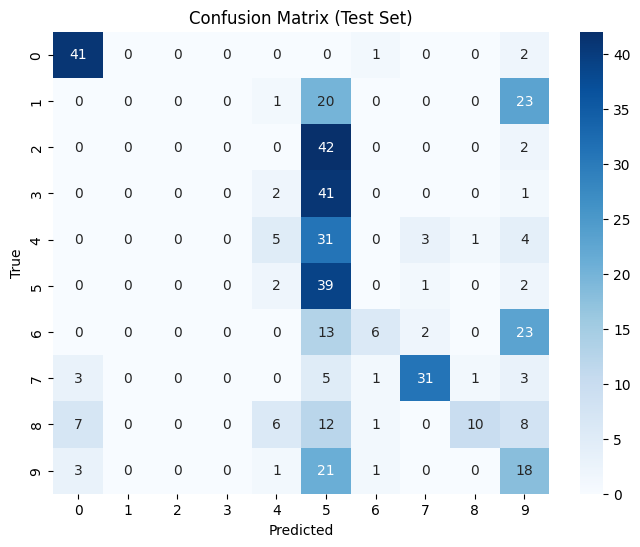

In [71]:
# Calculate confusion matrix and metrics for the test set
test_true_labels = np.argmax(y_test, axis=1)
test_confusion_matrix = confusion_matrix(test_true_labels, predictions)
test_classification_report = classification_report(test_true_labels, predictions, target_names=[str(label) for label in class_labels])

# Print and display the confusion matrix and metrics for the test set
print("Confusion Matrix (Test Set):")
print(test_confusion_matrix)

print("\nClassification Report (Test Set):")
print(test_classification_report)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()


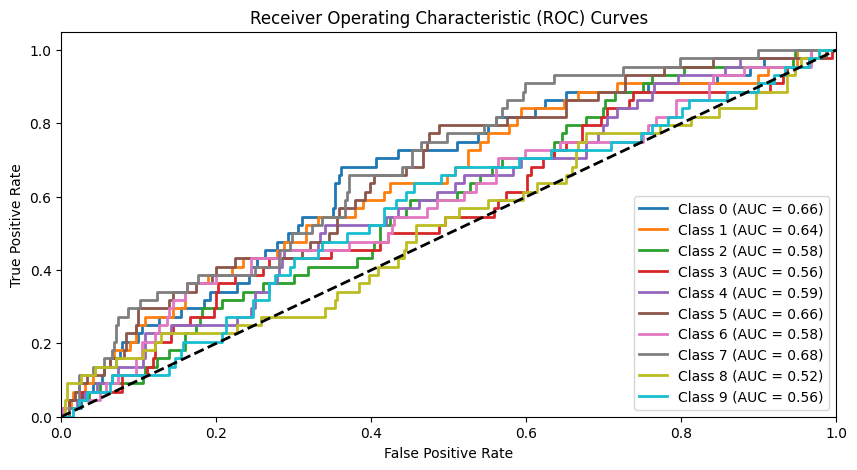

In [72]:
# Plot ROC curves
plt.figure(figsize=(10, 5))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(output_size):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], nntvt_784_2048_10_01_1000_do_25.forward(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

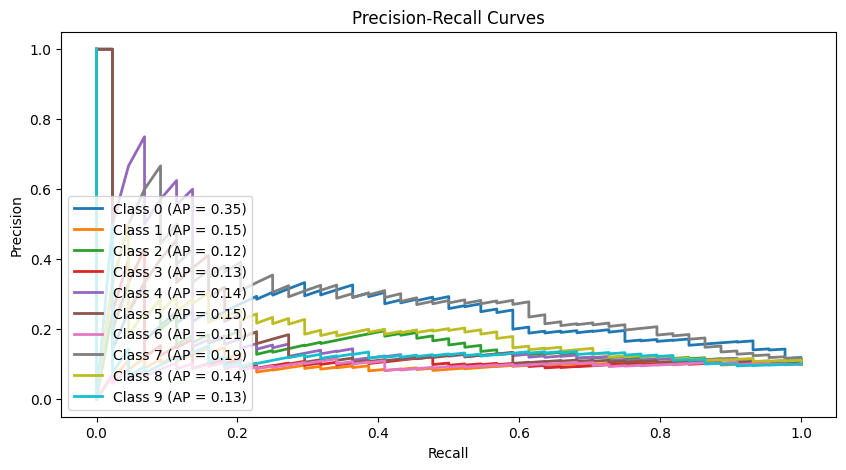

In [73]:
# Plot Precision-Recall curves
plt.figure(figsize=(10, 5))
precision = dict()
recall = dict()
average_precision = dict()
for i in range(output_size):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], nntvt_784_2048_10_01_1000_do_25.forward(X_test)[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], nntvt_784_2048_10_01_1000_do_25.forward(X_test)[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()


In [74]:
# Get the list of image names (assuming your filenames are available)
image_names = [filename for filename in os.listdir(test_dir) if filename.endswith('.jpg')]

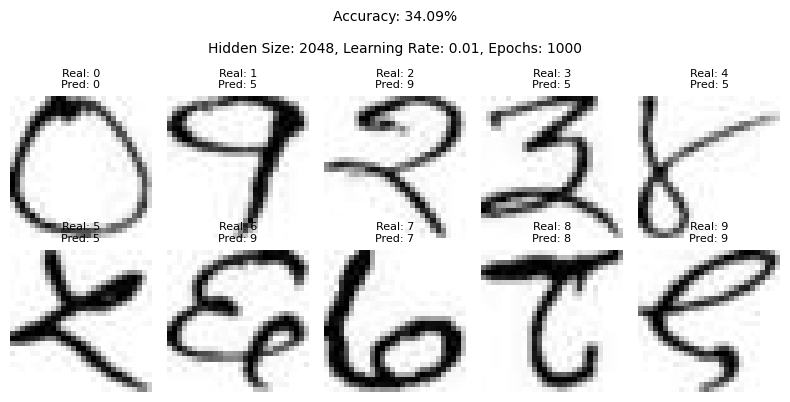

In [75]:
unique_labels = []

# Set the figure size and adjust the image size
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
for i, filename in enumerate(image_names):
    if len(unique_labels) == 10:
        break

    image = X_test[i].reshape(28, 28)
    label = np.argmax(y_test[i])  # Convert one-hot encoding to label
    prediction = predictions[i]

    if label not in unique_labels:
        plt.subplot(2, 5, len(unique_labels) + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Real: {label}\nPred: {prediction}", fontsize=8)
        plt.axis('off')
        unique_labels.append(label)

# Add an overall title with accuracy
accuracy_text = f"Accuracy: {accuracy * 100:.2f}%\n\nHidden Size: {hidden_size}, Learning Rate: {learning_rate}, Epochs: {epochs}"
plt.suptitle(accuracy_text, fontsize=10, y=0.995)  # Adjust fontsize and position as needed
plt.tight_layout()
plt.show()


# Sample

In [ ]:

import numpy as np

class Neuron:
  def __init__(self, weights, bias):
    self.weights = weights
    self.bias = bias



In [ ]:
def forward_propagate(self, X):
    # Feed forward input X through a network
    H = self.sigmoid(np.dot(X, self.W1))
    Y = self.sigmoid(np.dot(H, self.W2))
    return H, Y


In [ ]:
def back_propagate(self, X, H, Y, y_true):
    # Back propagate errors and update weights
    m = X.shape[0]
    error = Y - y_true
    dW2 = (1/m) * np.dot(H.T, error)
    dH = np.dot(error, self.W2.T) * self.sigmoid_derivative(H)
    dW1 = (1/m) * np.dot(X.T, dH)
    return dW1, dW2


In [ ]:
def initialize_weights(self, input_size, hidden_size, output_size):
    # Initialize weights randomly with a mean of 0
    W1 = np.random.randn(input_size, hidden_size)
    W2 = np.random.randn(hidden_size, output_size)
    return W1, W2


In [ ]:
def update_weights(self, dW1, dW2, learning_rate):
    # Update weights using gradient descent
    self.W1 -= learning_rate * dW1
    self.W2 -= learning_rate * dW2



In [ ]:
%ls
%cd /content/gdrive/Shareddrives/31005_Machine_Learning/trial
!ls
%pwd


dataset/
/content/gdrive/Shareddrives/31005_Machine_Learning/trial
dataset


'/content/gdrive/Shareddrives/31005_Machine_Learning/trial'

In [ ]:
# Define the source directory where the digit folders are located
source_dir = './dataset/numerals'  # Replace with the path to your images folder

# Define the destination directories for train, validation, and test splits
train_dir = './dataset/numerals_train'
validation_dir = './dataset/numerals_validation'
test_dir = './dataset/numerals_test'

# Create destination directories if they don't exist
for directory in [train_dir, validation_dir, test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

%pwd ## everything is like /content/gdrive/Shareddrives/31005_Machine_Learning/trial/dataset/numerals_test

'/content/gdrive/Shareddrives/31005_Machine_Learning/trial'

In [ ]:
%cd /content/gdrive/Shareddrives/31005_Machine_Learning/trial
# Initialize counters for each class
class_counts = {str(i): 0 for i in range(10)}
source_dir = '/content/gdrive/Shareddrives/31005_Machine_Learning/dataset/numerals'
# Iterate through each digit folder (0 to 9)
for digit in range(10):
    digit_folder = os.path.join(source_dir, str(digit))

    # Get a list of image files in the folder
    image_files = [filename for filename in os.listdir(digit_folder) if filename.endswith('.jpg')]

    # Split the image files into train, validation, and test sets
    train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    # Copy images to the respective directories with modified names
    for filename in train_files:
        src_path = os.path.join(digit_folder, filename)
        dst_filename = f"{digit}_{filename}"  # Modified filename
        dst_path = os.path.join(train_dir, dst_filename)
        shutil.copy(src_path, dst_path)
        class_counts[str(digit)] += 1

    for filename in val_files:
        src_path = os.path.join(digit_folder, filename)
        dst_filename = f"{digit}_{filename}"  # Modified filename
        dst_path = os.path.join(validation_dir, dst_filename)
        shutil.copy(src_path, dst_path)
        class_counts[str(digit)] += 1

    for filename in test_files:
        src_path = os.path.join(digit_folder, filename)
        dst_filename = f"{digit}_{filename}"  # Modified filename
        dst_path = os.path.join(test_dir, dst_filename)
        shutil.copy(src_path, dst_path)
        class_counts[str(digit)] += 1


/content/gdrive/Shareddrives/31005_Machine_Learning/trial


In [ ]:
def load_and_preprocess_images_from_directory(directory):
    print(f"Loading and Preprocessing Data from {directory}")
    images = []
    labels = []
    problematic_files = []  # List to store problematic file names
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            parts = filename.split('_')  # Split the filename into label and original name parts
            # print(parts)
            # print(len(parts))
            if len(parts) == 3:
                # print("inside len(parts)")
                label = int(parts[0])  # Extract the label from the filename
                try:
                    # Load the image and preprocess it (resize and normalize)
                    image = Image.open(os.path.join(directory, filename)).convert('L')  # Convert to grayscale
                    image = image.resize((32, 32))  # Resize to a consistent size
                    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]

                    # Append the preprocessed image and label
                    images.append(image)
                    labels.append(label)
                    # print(f"image {image} and label {label}")
                except Exception as e:
                    # If there's an error while processing the image, log the filename
                    problematic_files.append(filename)
                    print(f"Error processing {filename}: {str(e)}")

    if problematic_files:
        print("Problematic files:", problematic_files)

    sys.stdout.flush()  # Force the output to be displayed immediately

    return np.array(images), np.array(labels)

In [ ]:
# Load and preprocess the images from train, validation, and test directories
X_train, y_train = load_and_preprocess_images_from_directory(train_dir)
X_val, y_val = load_and_preprocess_images_from_directory(validation_dir)
X_test, y_test = load_and_preprocess_images_from_directory(test_dir)

Loading and Preprocessing Data from ./dataset/numerals_train
Loading and Preprocessing Data from ./dataset/numerals_validation
Loading and Preprocessing Data from ./dataset/numerals_test


In [ ]:
print(f"X_train: {X_train} \ny_train: {y_train}")
print(f"X_train.shape: {X_train.shape} \ny_train.shape: {y_train.shape}")

X_train: [[[0.98431373 0.92941176 0.97647059 ... 1.         0.98823529 0.96862745]
  [0.9372549  0.90980392 1.         ... 0.98823529 0.97647059 0.96862745]
  [0.98431373 0.98039216 0.86666667 ... 0.98823529 0.97647059 0.97647059]
  ...
  [1.         0.96470588 0.95686275 ... 1.         0.99215686 0.97254902]
  [0.99215686 1.         1.         ... 0.99215686 0.97254902 0.95686275]
  [0.96862745 0.98823529 1.         ... 0.98039216 0.96862745 0.97254902]]

 [[1.         1.         0.97254902 ... 0.99607843 0.97647059 0.96862745]
  [0.98431373 0.99607843 0.99607843 ... 1.         0.98431373 0.96470588]
  [0.98039216 0.99607843 1.         ... 0.88235294 0.98823529 0.99215686]
  ...
  [1.         0.83137255 0.56078431 ... 0.99607843 1.         1.        ]
  [0.98823529 0.97254902 0.9254902  ... 0.99607843 1.         1.        ]
  [0.98039216 0.99607843 1.         ... 0.99607843 1.         1.        ]]

 [[1.         0.98823529 0.95686275 ... 0.99215686 0.99607843 1.        ]
  [0.98431373

In [ ]:
# from tensorflow.keras.utils import to_categorical

# Normalize images
X_train_normalized = X_train.astype('float32') / 255.0
X_val_normalized = X_val.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

# do not hot-code
# # One-hot encode labels
# y_train = to_categorical(y_train, 10)
# y_val = to_categorical(y_val, 10)
# y_test = to_categorical(y_test, 10)


In [ ]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights and biases
        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.bias_hidden = np.zeros((1, self.hidden_size))
        self.weights_hidden_output = np.random.randn(self.hidden_size, self.output_size)
        self.bias_output = np.zeros((1, self.output_size))

    def forward(self, X):
      # Flatten the input
      X_flat = X.reshape(X.shape[0], -1)

      # # Forward pass
      # self.z_hidden = np.dot(X_flat, self.weights_input_hidden) + self.bias_hidden
      # self.a_hidden = sigmoid(self.z_hidden)
      # self.z_output = np.dot(self.a_hidden, self.weights_hidden_output) + self.bias_output
      # self.a_output = softmax(self.z_output)


      H = sigmoid(np.dot(X_flat, self.weights_input_hidden))
      Y = sigmoid(np.dot(H, self.weights_hidden_output))
      return H, Y

    # def backward(self, X, H, Y, y_true, learning_rate):

    #   m = X.shape[0]
    #    # Reshape X_batch to (batch_size, input_size)
    #   X_flat = X.reshape((m, -1))
    #   error = Y - y_true
    #   dW2 = (1/m) * np.dot(H.T, error)
    #   dH = np.dot(error, self.weights_hidden_output.T) * sigmoid_derivative(H)
    #   dW1 = (1/m) * np.dot(X.T, dH)
    #   return dW1, dW2

    # def backward(self, X, H, Y, y_true, learning_rate):
    #   m = X.shape[0]

    #   # Calculate the error
    #   error = Y
    #   error[np.arange(m), y_true] -= 1  # This adjusts the values for the true class indices

    #   # Calculate gradients
    #   dW2 = (1/m) * np.dot(H.T, error)
    #   dH = np.dot(error, self.W2.T) * self.sigmoid_derivative(H)
    #   dW1 = (1/m) * np.dot(X.T, dH)

    #   # Update weights using gradient descent
    #   self.update_weights(dW1, dW2, learning_rate)
    def backward(self, X, H, Y, y_true, learning_rate):
      m = X.shape[0]

      # Reshape X_batch to (batch_size, input_size)
      X_flat = X.reshape((m, -1))

      # Reshape y_true to have the same shape as Y
      y_true_one_hot = np.zeros_like(Y)
      y_true_one_hot[np.arange(m), y_true] = 1

      # Calculate the error
      error = Y - y_true_one_hot

      # Calculate gradients
      dW2 = (1/m) * np.dot(H.T, error)
      dH = np.dot(error, self.weights_hidden_output.T) * sigmoid_derivative(H)
      dW1 = (1/m) * np.dot(X_flat.T, dH)

      return dW1, dW2



      # # Backpropagation
      # m = X.shape[0]

      # # Reshape X_batch to (batch_size, input_size)
      # X_flat = X.reshape((m, -1))

      # # Calculate loss (cross-entropy loss for integer labels)
      # epsilon = 1e-10  # Small epsilon value
      # loss = -np.sum(np.log(self.a_output[np.arange(m), y] + epsilon)) / m

      # # Calculate gradients
      # d_output = np.zeros_like(self.a_output)
      # d_output[np.arange(m), y] = -(1 / self.a_output[np.arange(m), y]) / m
      # d_weights_hidden_output = np.dot(self.a_hidden.T, d_output)
      # d_bias_output = np.sum(d_output, axis=0, keepdims=True)
      # d_hidden = np.dot(d_output, self.weights_hidden_output.T) * (self.a_hidden * (1 - self.a_hidden))
      # d_weights_input_hidden = np.dot(X_flat.T, d_hidden)
      # d_bias_hidden = np.sum(d_hidden, axis=0)

      # # Gradient Clipping for d_weights_hidden_output
      # max_gradient = 1.0  # Set your desired maximum gradient value
      # if np.linalg.norm(d_weights_hidden_output) > max_gradient:
      #     d_weights_hidden_output = d_weights_hidden_output / np.linalg.norm(d_weights_hidden_output) * max_gradient


      # # Update weights and biases
      # self.weights_hidden_output -= learning_rate * d_weights_hidden_output
      # self.bias_output -= learning_rate * d_bias_output
      # self.weights_input_hidden -= learning_rate * d_weights_input_hidden
      # self.bias_hidden -= learning_rate * d_bias_hidden

      # return loss

    def cross_entropy_loss(self, y_true, y_pred):
      # y_true: True class labels (class indices, not one-hot encoded)
      # y_pred: Predicted class probabilities
      epsilon = 1e-15  # Small constant to avoid log(0)
      num_samples = len(y_true)

      # Select the predicted probabilities for the true class labels
      y_pred_for_true_labels = y_pred[np.arange(num_samples), y_true]

      # Calculate the cross-entropy loss
      loss = -np.sum(np.log(y_pred_for_true_labels + epsilon)) / num_samples

      return loss



    def train(self, X, y, learning_rate, epochs, batch_size):
        for epoch in range(epochs):
            # Forward and backward pass for each batch
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                output, y_pred = self.forward(X_batch)
                # print(f"y_pred {i}: {y_pred}")
                # print(f"y_batch {i}: {y_batch}")
                loss = self.cross_entropy_loss(y_batch, y_pred)
                dW1, dW2= self.backward(X_batch, output, y_pred, y_batch, learning_rate)

                # Print loss for monitoring
                if i % 1000 == 0:
                    print(f'Epoch {epoch + 1}/{epochs}, Batch {i}/{X.shape[0]}, Loss: {loss:.4f}')

            # Print epoch progress
            print(f'Epoch {epoch + 1}/{epochs} completed. Loss: {loss:.4f}')

    def predict(self, X):
        # Predict class labels for input data
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)


In [ ]:
# Define activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip to avoid overflow

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def sigmoid_derivative(x):
    # Derivative of the sigmoid function
    return x * (1 - x)

In [ ]:
def relu(x):
    # ReLU activation function
    return np.maximum(0, x)

def relu_derivative(x):
    # Derivative of the ReLU activation function
    return np.where(x > 0, 1, 0)

def he_initialization(input_size, output_size):
    he_variance = 2.0 / input_size
    weights = np.random.randn(input_size, output_size) * np.sqrt(he_variance)
    return weights

class NeuralNetworkReLu:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights and biases using He initialization
        self.weights_input_hidden = he_initialization(self.input_size, self.hidden_size)
        self.bias_hidden = np.zeros((1, self.hidden_size))
        self.weights_hidden_output = he_initialization(self.hidden_size, self.output_size)
        self.bias_output = np.zeros((1, self.output_size))

    def forward(self, X):
        # Flatten the input
        X_flat = X.reshape(X.shape[0], -1)

        # Forward pass
        H = relu(np.dot(X_flat, self.weights_input_hidden) + self.bias_hidden)
        Y = sigmoid(np.dot(H, self.weights_hidden_output) + self.bias_output)  # Using sigmoid for output

        return H, Y

    def backward(self, X, H, Y, y_true, learning_rate):
        m = X.shape[0]

        # Reshape X_batch to (batch_size, input_size)
        X_flat = X.reshape((m, -1))

        # Reshape y_true to have the same shape as Y
        y_true_one_hot = np.zeros_like(Y)
        y_true_one_hot[np.arange(m), y_true] = 1

        # Calculate the error
        error = Y - y_true_one_hot

        # Calculate gradients
        dW2 = (1 / m) * np.dot(H.T, error)
        dH = np.dot(error, self.weights_hidden_output.T) * relu_derivative(H)
        dW1 = (1 / m) * np.dot(X_flat.T, dH)

        # Update weights and biases
        self.weights_hidden_output -= learning_rate * dW2
        self.bias_output -= learning_rate * np.sum(error, axis=0, keepdims=True)
        self.weights_input_hidden -= learning_rate * dW1
        self.bias_hidden -= learning_rate * np.sum(dH, axis=0, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15
        num_samples = len(y_true)

        # Select the predicted probabilities for the true class labels
        y_pred_for_true_labels = y_pred[np.arange(num_samples), y_true]

        # Calculate the cross-entropy loss
        loss = -np.sum(np.log(y_pred_for_true_labels + epsilon)) / num_samples

        return loss

    def accuracy(self, y_true, y_pred):
      # Calculate the accuracy of predictions
      num_samples = len(y_true)
      correct_predictions = np.sum(y_true == y_pred)
      return correct_predictions / num_samples


    def train(self, X, y, learning_rate, epochs, batch_size):
      for epoch in range(epochs):
          total_loss = 0
          total_accuracy = 0
          num_batches = 0

          # Forward and backward pass for each batch
          for i in range(0, X.shape[0], batch_size):
              X_batch = X[i:i + batch_size]
              y_batch = y[i:i + batch_size]
              output, y_pred = self.forward(X_batch)
              loss = self.cross_entropy_loss(y_batch, y_pred)
              self.backward(X_batch, output, y_pred, y_batch, learning_rate)

              total_loss += loss
              total_accuracy += self.accuracy(y_batch, self.predict(X_batch))
              num_batches += 1

              # Print loss and accuracy for monitoring
              if i % 1000 == 0:
                  print(f'Epoch {epoch + 1}/{epochs}, Batch {i}/{X.shape[0]}, Loss: {loss:.4f}, Accuracy: {total_accuracy/num_batches:.4f}')

          # Calculate and print average loss and accuracy for the epoch
          average_loss = total_loss / num_batches
          average_accuracy = total_accuracy / num_batches
          print(f'Epoch {epoch + 1}/{epochs} completed. Average Loss: {average_loss:.4f}, Average Accuracy: {average_accuracy:.4f}')


    def predict(self, X):
        # Predict class labels for input data
        _, y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)


In [ ]:
# Set hyperparameters
input_size = 32 * 32  # Adjust this based on your image size
hidden_size = 64  # Number of neurons in the hidden layer
output_size = 10  # Number of output classes
learning_rate = 0.001
batch_size = 32
epochs = 500

In [ ]:
# Create the neural network
nn = NeuralNetwork(input_size, hidden_size, output_size)

In [ ]:
# Create the neural network
nnRL = NeuralNetworkReLu(input_size, hidden_size, output_size)

In [ ]:
# Set hyperparameters
input_size = 32 * 32  # Adjust this based on your image size
hidden_size = 32  # Number of neurons in the hidden layer
output_size = 10  # Number of output classes
learning_rate = 0.01
batch_size = 32
epochs = 500
# Create the neural network
nnRL = NeuralNetworkReLu(input_size, hidden_size, output_size)
nnRL.train(X_train_normalized, y_train, learning_rate, epochs, batch_size)

Epoch 1/500, Batch 0/2010, Loss: 0.6937, Accuracy: 1.0000
Epoch 1/500 completed. Average Loss: 1.6543, Average Accuracy: 0.5184
Epoch 2/500, Batch 0/2010, Loss: 3.7976, Accuracy: 0.0000
Epoch 2/500 completed. Average Loss: 2.2212, Average Accuracy: 0.3914
Epoch 3/500, Batch 0/2010, Loss: 3.7140, Accuracy: 0.0000
Epoch 3/500 completed. Average Loss: 2.2366, Average Accuracy: 0.3914
Epoch 4/500, Batch 0/2010, Loss: 3.6542, Accuracy: 0.0000
Epoch 4/500 completed. Average Loss: 2.2403, Average Accuracy: 0.3914
Epoch 5/500, Batch 0/2010, Loss: 3.5946, Accuracy: 0.0000
Epoch 5/500 completed. Average Loss: 2.2428, Average Accuracy: 0.3914
Epoch 6/500, Batch 0/2010, Loss: 3.5331, Accuracy: 0.0000
Epoch 6/500 completed. Average Loss: 2.2449, Average Accuracy: 0.3914
Epoch 7/500, Batch 0/2010, Loss: 3.4703, Accuracy: 0.0000
Epoch 7/500 completed. Average Loss: 2.2468, Average Accuracy: 0.3755
Epoch 8/500, Batch 0/2010, Loss: 3.4075, Accuracy: 0.0000
Epoch 8/500 completed. Average Loss: 2.2485, A

In [ ]:
nnRL.train(X_train_normalized, y_train, learning_rate, epochs, batch_size)

Epoch 1/500, Batch 0/2010, Loss: 0.6950, Accuracy: 1.0000
Epoch 1/500 completed. Average Loss: 1.1017, Average Accuracy: 0.2197
Epoch 2/500, Batch 0/2010, Loss: 1.3865, Accuracy: 0.0000
Epoch 2/500 completed. Average Loss: 1.6227, Average Accuracy: 0.0997
Epoch 3/500, Batch 0/2010, Loss: 1.8123, Accuracy: 0.0000
Epoch 3/500 completed. Average Loss: 1.9118, Average Accuracy: 0.1131
Epoch 4/500, Batch 0/2010, Loss: 2.0501, Accuracy: 0.0000
Epoch 4/500 completed. Average Loss: 2.0712, Average Accuracy: 0.1438
Epoch 5/500, Batch 0/2010, Loss: 2.1998, Accuracy: 0.0000
Epoch 5/500 completed. Average Loss: 2.1658, Average Accuracy: 0.1394
Epoch 6/500, Batch 0/2010, Loss: 2.2922, Accuracy: 0.0000
Epoch 6/500 completed. Average Loss: 2.2224, Average Accuracy: 0.1478
Epoch 7/500, Batch 0/2010, Loss: 2.3499, Accuracy: 0.0000
Epoch 7/500 completed. Average Loss: 2.2569, Average Accuracy: 0.1567
Epoch 8/500, Batch 0/2010, Loss: 2.3862, Accuracy: 0.0000
Epoch 8/500 completed. Average Loss: 2.2779, A

In [ ]:
nn.train(X_train_normalized, y_train, learning_rate, epochs, batch_size)

Epoch 1/50, Batch 0/2010, Loss: 0.2192
Epoch 1/50 completed. Loss: 3.7188
Epoch 2/50, Batch 0/2010, Loss: 0.2192
Epoch 2/50 completed. Loss: 3.7188
Epoch 3/50, Batch 0/2010, Loss: 0.2192
Epoch 3/50 completed. Loss: 3.7188
Epoch 4/50, Batch 0/2010, Loss: 0.2192
Epoch 4/50 completed. Loss: 3.7188
Epoch 5/50, Batch 0/2010, Loss: 0.2192
Epoch 5/50 completed. Loss: 3.7188
Epoch 6/50, Batch 0/2010, Loss: 0.2192
Epoch 6/50 completed. Loss: 3.7188
Epoch 7/50, Batch 0/2010, Loss: 0.2192
Epoch 7/50 completed. Loss: 3.7188
Epoch 8/50, Batch 0/2010, Loss: 0.2192
Epoch 8/50 completed. Loss: 3.7188
Epoch 9/50, Batch 0/2010, Loss: 0.2192
Epoch 9/50 completed. Loss: 3.7188
Epoch 10/50, Batch 0/2010, Loss: 0.2192
Epoch 10/50 completed. Loss: 3.7188
Epoch 11/50, Batch 0/2010, Loss: 0.2192
Epoch 11/50 completed. Loss: 3.7188
Epoch 12/50, Batch 0/2010, Loss: 0.2192
Epoch 12/50 completed. Loss: 3.7188
Epoch 13/50, Batch 0/2010, Loss: 0.2192
Epoch 13/50 completed. Loss: 3.7188
Epoch 14/50, Batch 0/2010, Los

In [ ]:
nn.train(X_train_normalized, y_train, learning_rate, epochs, batch_size)

Epoch 1/10, Batch 0/2010, Loss: 0.7304
Epoch 1/10 completed. Loss: 0.0031
Epoch 2/10, Batch 0/2010, Loss: 0.7304
Epoch 2/10 completed. Loss: 0.0031
Epoch 3/10, Batch 0/2010, Loss: 0.7304
Epoch 3/10 completed. Loss: 0.0031
Epoch 4/10, Batch 0/2010, Loss: 0.7304
Epoch 4/10 completed. Loss: 0.0031
Epoch 5/10, Batch 0/2010, Loss: 0.7304
Epoch 5/10 completed. Loss: 0.0031
Epoch 6/10, Batch 0/2010, Loss: 0.7304
Epoch 6/10 completed. Loss: 0.0031
Epoch 7/10, Batch 0/2010, Loss: 0.7304
Epoch 7/10 completed. Loss: 0.0031
Epoch 8/10, Batch 0/2010, Loss: 0.7304
Epoch 8/10 completed. Loss: 0.0031
Epoch 9/10, Batch 0/2010, Loss: 0.7304
Epoch 9/10 completed. Loss: 0.0031
Epoch 10/10, Batch 0/2010, Loss: 0.7304
Epoch 10/10 completed. Loss: 0.0031


In [ ]:
nn.train(X_train_normalized, y_train, learning_rate, epochs, batch_size)

Epoch 1/10, Batch 0/2010, Loss: 2.2275
Epoch 1/10 completed. Loss: 0.0297
Epoch 2/10, Batch 0/2010, Loss: 2.2275
Epoch 2/10 completed. Loss: 0.0297
Epoch 3/10, Batch 0/2010, Loss: 2.2275
Epoch 3/10 completed. Loss: 0.0297
Epoch 4/10, Batch 0/2010, Loss: 2.2275
Epoch 4/10 completed. Loss: 0.0297
Epoch 5/10, Batch 0/2010, Loss: 2.2275
Epoch 5/10 completed. Loss: 0.0297
Epoch 6/10, Batch 0/2010, Loss: 2.2275
Epoch 6/10 completed. Loss: 0.0297
Epoch 7/10, Batch 0/2010, Loss: 2.2275
Epoch 7/10 completed. Loss: 0.0297
Epoch 8/10, Batch 0/2010, Loss: 2.2275
Epoch 8/10 completed. Loss: 0.0297
Epoch 9/10, Batch 0/2010, Loss: 2.2275
Epoch 9/10 completed. Loss: 0.0297
Epoch 10/10, Batch 0/2010, Loss: 2.2275
Epoch 10/10 completed. Loss: 0.0297


In [ ]:
nn.train(X_train_normalized, y_train, learning_rate, epochs, batch_size)

Epoch 1/10, Batch 0/2010, Loss: 3.5961
Epoch 1/10 completed. Loss: 0.0212
Epoch 2/10, Batch 0/2010, Loss: 3.5961
Epoch 2/10 completed. Loss: 0.0212
Epoch 3/10, Batch 0/2010, Loss: 3.5961
Epoch 3/10 completed. Loss: 0.0212
Epoch 4/10, Batch 0/2010, Loss: 3.5961
Epoch 4/10 completed. Loss: 0.0212
Epoch 5/10, Batch 0/2010, Loss: 3.5961
Epoch 5/10 completed. Loss: 0.0212
Epoch 6/10, Batch 0/2010, Loss: 3.5961
Epoch 6/10 completed. Loss: 0.0212
Epoch 7/10, Batch 0/2010, Loss: 3.5961
Epoch 7/10 completed. Loss: 0.0212
Epoch 8/10, Batch 0/2010, Loss: 3.5961
Epoch 8/10 completed. Loss: 0.0212
Epoch 9/10, Batch 0/2010, Loss: 3.5961
Epoch 9/10 completed. Loss: 0.0212
Epoch 10/10, Batch 0/2010, Loss: 3.5961
Epoch 10/10 completed. Loss: 0.0212


In [ ]:
nn.train(X_train_normalized, y_train, learning_rate, epochs, batch_size)

Epoch 1/10, Batch 0/2010, Loss: 10.5866
Epoch 1/10 completed. Loss: 0.1911
Epoch 2/10, Batch 0/2010, Loss: 10.5866
Epoch 2/10 completed. Loss: 0.1911
Epoch 3/10, Batch 0/2010, Loss: 10.5866
Epoch 3/10 completed. Loss: 0.1911
Epoch 4/10, Batch 0/2010, Loss: 10.5866
Epoch 4/10 completed. Loss: 0.1911
Epoch 5/10, Batch 0/2010, Loss: 10.5866
Epoch 5/10 completed. Loss: 0.1911
Epoch 6/10, Batch 0/2010, Loss: 10.5866
Epoch 6/10 completed. Loss: 0.1911
Epoch 7/10, Batch 0/2010, Loss: 10.5866
Epoch 7/10 completed. Loss: 0.1911
Epoch 8/10, Batch 0/2010, Loss: 10.5866
Epoch 8/10 completed. Loss: 0.1911
Epoch 9/10, Batch 0/2010, Loss: 10.5866
Epoch 9/10 completed. Loss: 0.1911
Epoch 10/10, Batch 0/2010, Loss: 10.5866
Epoch 10/10 completed. Loss: 0.1911


In [ ]:
nn.train(X_train_normalized, y_train, learning_rate, epochs, batch_size)

y_pred 0: [[0.54217691 0.0053759  0.99174591 ... 0.99102187 0.97066692 0.99915547]
 [0.54094469 0.00546152 0.99226616 ... 0.9924844  0.97481272 0.99928091]
 [0.50116006 0.0054941  0.99106205 ... 0.99183902 0.97062222 0.99913301]
 ...
 [0.50906432 0.00565192 0.99304281 ... 0.98932106 0.9722432  0.9992248 ]
 [0.52361355 0.00780445 0.9912541  ... 0.99121751 0.97274402 0.99927867]
 [0.51632734 0.00724197 0.99129882 ... 0.99059383 0.97616082 0.99924388]]
y_batch 0: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Epoch 1/10, Bat

In [ ]:
nn.train(X_train_normalized, y_train, learning_rate, epochs, batch_size)

y_pred 0: [[1.03702248e-03 1.19909857e-06 1.47404437e-03 ... 9.81282905e-01
  4.71884886e-03 3.60414844e-06]
 [8.63751613e-04 1.16967707e-06 1.58342502e-03 ... 9.84136677e-01
  2.32484524e-03 4.23262754e-06]
 [1.06785751e-03 1.79640123e-06 2.01530145e-03 ... 9.78947248e-01
  3.20603329e-03 5.51777178e-06]
 ...
 [9.32889525e-04 1.41096123e-06 1.96517264e-03 ... 9.80737081e-01
  2.21129708e-03 4.75257890e-06]
 [8.91742920e-04 1.50584397e-06 1.97415820e-03 ... 9.78541801e-01
  2.82397984e-03 4.32929861e-06]
 [8.20662008e-04 1.52865695e-06 1.93515100e-03 ... 9.76607745e-01
  3.26978371e-03 4.08980730e-06]]
y_batch 0: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0

<ipython-input-103-ba5d5fe42e2b>:38: RuntimeWarning: divide by zero encountered in divide
  d_output[np.arange(m), y] = -(1 / self.a_output[np.arange(m), y]) / m
<ipython-input-103-ba5d5fe42e2b>:41: RuntimeWarning: invalid value encountered in multiply
  d_hidden = np.dot(d_output, self.weights_hidden_output.T) * (self.a_hidden * (1 - self.a_hidden))
<ipython-input-103-ba5d5fe42e2b>:48: RuntimeWarning: invalid value encountered in divide
  d_weights_hidden_output = d_weights_hidden_output / np.linalg.norm(d_weights_hidden_output) * max_gradient


y_pred 1024: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
y_batch 1024: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
y_pred 1280: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
y_batch 1280: [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6

In [ ]:
print(X_train.shape)
print(X_train.shape[0])
print(X_train_normalized.shape)
print(X_train_normalized.shape[0])


print(X_val_normalized.shape[0])

print(X_test_normalized.shape[0])


(2010, 32, 32)
2010
(2010, 32, 32)
2010
430
440


In [ ]:
nn.train(X_train_normalized, y_train, learning_rate, epochs, batch_size)

y_pred 0: [[9.21149707e-01 1.74709263e-07 3.26576818e-06 1.92587118e-06
  3.11390515e-07 1.79584260e-02 6.02386542e-02 6.45848347e-04
  1.65430160e-06 3.19342588e-08]
 [9.43496641e-01 1.27458920e-07 3.27247711e-06 1.69750008e-06
  2.33161775e-07 1.50207734e-02 4.10253650e-02 4.50734879e-04
  1.13111191e-06 2.35691839e-08]
 [9.44262530e-01 1.27628509e-07 2.95541572e-06 2.14353460e-06
  2.58590291e-07 1.42845829e-02 4.09845084e-02 4.61438791e-04
  1.42978482e-06 2.53235143e-08]
 [9.17395560e-01 1.50279267e-07 3.52793710e-06 1.76503156e-06
  2.92847999e-07 2.29817192e-02 5.89726816e-02 6.42995207e-04
  1.28053702e-06 2.77951971e-08]
 [9.25603542e-01 1.87361362e-07 3.54006681e-06 2.26152146e-06
  3.16186634e-07 1.87779510e-02 5.49666420e-02 6.43826986e-04
  1.69455168e-06 3.81183339e-08]
 [9.33200400e-01 1.58545198e-07 3.04266935e-06 2.14193365e-06
  3.02780176e-07 1.68674047e-02 4.93620437e-02 5.63071836e-04
  1.40289672e-06 3.04800266e-08]
 [9.32999084e-01 1.54706567e-07 2.74448498e-06 2

<ipython-input-83-aa99b4f79a76>:38: RuntimeWarning: divide by zero encountered in divide
  d_output[np.arange(m), y] = -(1 / self.a_output[np.arange(m), y]) / m
<ipython-input-83-aa99b4f79a76>:41: RuntimeWarning: invalid value encountered in multiply
  d_hidden = np.dot(d_output, self.weights_hidden_output.T) * (self.a_hidden * (1 - self.a_hidden))
<ipython-input-83-aa99b4f79a76>:48: RuntimeWarning: invalid value encountered in divide
  d_weights_hidden_output = d_weights_hidden_output / np.linalg.norm(d_weights_hidden_output) * max_gradient


Streaming output truncated to the last 5000 lines.
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [n

(2010, 32, 32)
(2010,)
(440, 32, 32)
0
(2010, 32, 32)
(2010,)
(440, 32, 32)
0


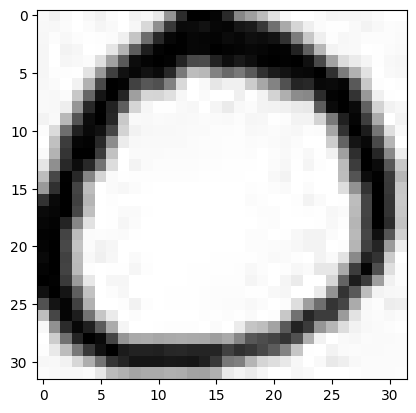

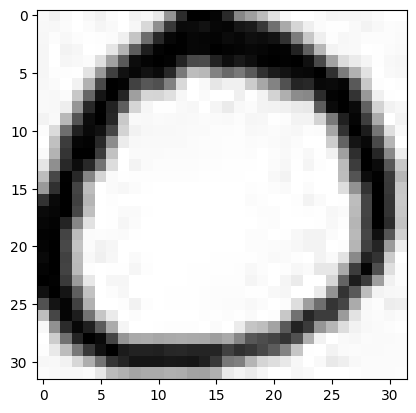

In [ ]:
import matplotlib.pyplot as plt
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
plt.imshow(X_test[9], cmap='gray')
print(y_test[9])

print(np.shape(X_train_normalized))
print(np.shape(y_train))
print(np.shape(X_test_normalized))
plt.figure();
plt.imshow(X_test_normalized[9], cmap='gray')
print(y_test[9])



# Below is from Scaler
https://www.scaler.com/topics/deep-learning/how-to-build-a-neural-network/

In [ ]:
import numpy as np

class Model:
  def __init__(self, input_size, hidden_size, output_size):
    self.W1, self.W2 = self.initialize_weights(input_size, hidden_size, output_size)

  def sigmoid(self, x):
    # Activation function
    return 1/(1+np.exp(-x))

  def sigmoid_derivative(self, x):
    # Derivative of the sigmoid function
    return x * (1 - x)

  def initialize_weights(self, input_size, hidden_size, output_size):
    # Initialize weights randomly with a mean of 0
    W1 = np.random.randn(input_size, hidden_size)
    W2 = np.random.randn(hidden_size, output_size)
    return W1, W2

  def forward_propagate(self, X):
    # Feed forward input X through a network
    H = self.sigmoid(np.dot(X, self.W1))
    Y = self.sigmoid(np.dot(H, self.W2))
    return H, Y


  def back_propagate(self, X, H, Y, y_true):
    # Back propagate errors and update weights
    m = X.shape[0]
    error = Y - y_true
    dW2 = (1/m) * np.dot(H.T, error)
    dH = np.dot(error, self.W2.T) * self.sigmoid_derivative(H)
    dW1 = (1/m) * np.dot(X.T, dH)
    return dW1, dW2

  def update_weights(self, dW1, dW2, learning_rate):
    # Update weights using gradient descent
    self.W1 -= learning_rate * dW1
    self.W2 -= learning_rate * dW2

  def optimize(self, X, y_true, num_epochs, learning_rate, batch_size):
    for epoch in range(num_epochs):
      print(f"Epoch {epoch + 1}/{num_epochs}")
      # Shuffle data
      shuffled_indices = np.random.permutation(X.shape[0])
      X = X[shuffled_indices]
      y_true = y_true[shuffled_indices]

      # Split data into mini-batches
      num_batches = X.shape[0] // batch_size
      for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = start_index + batch_size
        X_batch = X[start_index:end_index]
        y_batch = y_true[start_index:end_index]

        # Feed forward
        H, Y = self.forward_propagate(X_batch)

        # Back propagate
        dW1, dW2 = self.back_propagate(X_batch, H, Y, y_batch)

        # Update weights
        self.update_weights(dW1, dW2, learning_rate)
        print(f"Feed forward: H {H} and Y {Y} forwa\n Back Prop: dW1 {dW1} and dW2 {dW2}")

    return


In [ ]:
# Create model
model = Model(input_size=784, hidden_size=64, output_size=10) ## input_size=784 because image size is 28 x 28


In [ ]:
# Create model
model = Model(input_size=1024, hidden_size=64, output_size=10) ## input_size=784 because image size is 32 x 32

In [ ]:
# Train model
model.optimize(X_train, y_train, num_epochs=10, learning_rate=0.01, batch_size=6)

Epoch 1/10


ValueError: ignored

In [ ]:
# Evaluate model
H, Y = model.forward_propagate(X_test)
predictions = np.argmax(Y, axis=1)
accuracy = np.mean(predictions == np.argmax(y_test, axis=1))
print(f'Accuracy: {accuracy:.4f}')